# 0.0. BIBLIOTECAS E IMPORTS

In [1]:
import math
import numpy as np
import pandas as pd
import pickle
import inflection
import random as rd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image

import datetime

from tabulate import tabulate

from scipy import stats as ss

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy

import xgboost as xgb

## 0.1. Funções Auxiliares

In [2]:
# settings function
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    
# cramer v function   
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    v = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))
    return v
        
    
# model error metrics function
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def mean_percentage_error(y_true, y_pred): 
    return np.mean(percentage_error(np.asarray(y_true), np.asarray(y_pred))) * 100


#def mean_percentage_error(y, yhat):
#    return np.mean((y - yhat) / y) * 100
#
#def mean_absolute_percentage_error(y, yhat):
#    return np.mean(np.abs((y - yhat) / y)) * 100


def ml_error(model_name, y, yhat):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])


# time series cross-validation function
def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list  = []
    mape_list = []
    rmse_list = []
    
    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #start & end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']
        
        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']
        
        # model
        m = model.fit(xtraining, ytraining)
        
        # prediction
        yhat = m.predict(xvalidation)
        
        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
                
        # store performance of each kfold iteration
        mae_list.append(m_result['MAE']) 
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Carregar os Dados

In [4]:
df_sales_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/raw/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [3]:
df1 = df_raw.copy()

In [4]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Renomear Colunas

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = map(snakecase, cols_old)

df1.columns = cols_new

In [6]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Dimensões dos Dados

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3. Tipos dos Dados

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checar Valores Ausentes (Valores NA)

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Tratar NA

In [11]:
# competition_distance
# preenchendo valores NA com valor bem acima do máximo
# se a distância é zero, pode ser uma loja muito distante ou não ter competição
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if 
                                                math.isnan(x['competition_open_since_month']) else 
                                                x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                math.isnan(x['competition_open_since_year']) else 
                                                x['competition_open_since_year'], axis=1)

# promo2_since_week 
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if 
                                     math.isnan(x['promo2_since_week']) else 
                                     x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if 
                                     math.isnan(x['promo2_since_year']) else 
                                     x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
             9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                             1 if x['month_map'] in 
                                                             x['promo_interval'].split(',') else 0, axis=1)

In [17]:
df1.sample(5).T

,645388,1016662,462117,763476,893811
store,589,568,178,487,367
day_of_week,6,2,2,5,7
date,2013-11-30 00:00:00,2013-01-01 00:00:00,2014-05-13 00:00:00,2013-08-16 00:00:00,2013-04-21 00:00:00
sales,3840,0,7786,7459,0
customers,442,0,809,745,0
open,1,0,1,1,0
promo,0,0,0,1,0
state_holiday,0,a,0,0,0
school_holiday,0,1,0,0,0
store_type,a,d,d,d,d


In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Alteração dos Tipos dos Dados

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [20]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [25]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


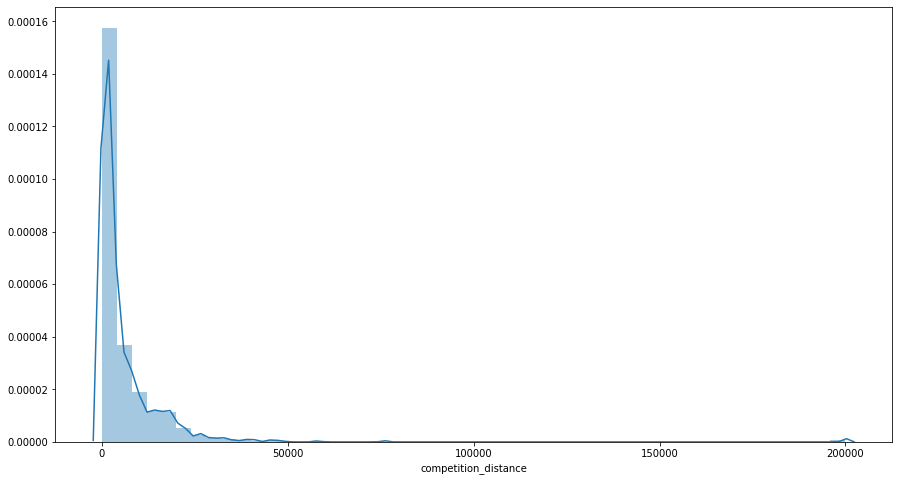

In [35]:
plt.figure(figsize=(15,8))
sns.distplot(df1['competition_distance']);

### 1.7.2. Categorical Attributes

In [30]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

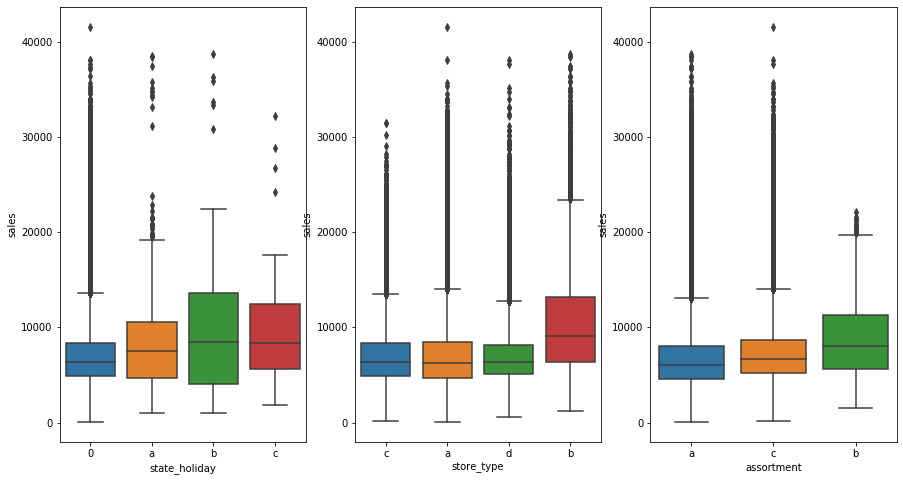

In [36]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.figure(figsize=(15,8))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

In [39]:
# Salvando modificações para carregar na próxima etapa
df1.to_csv('../data/interim/df_step01.csv', index=False)

# 2.0. PASSO 02 - ENGENHARIA DE VARIÁVEIS

In [2]:
# Carregando dados tratados da etapa anterior
df2 = pd.read_csv('../data/interim/df_step01.csv', low_memory=False, parse_dates=['date'])

## 2.1. Mapa Mental de Hipóteses

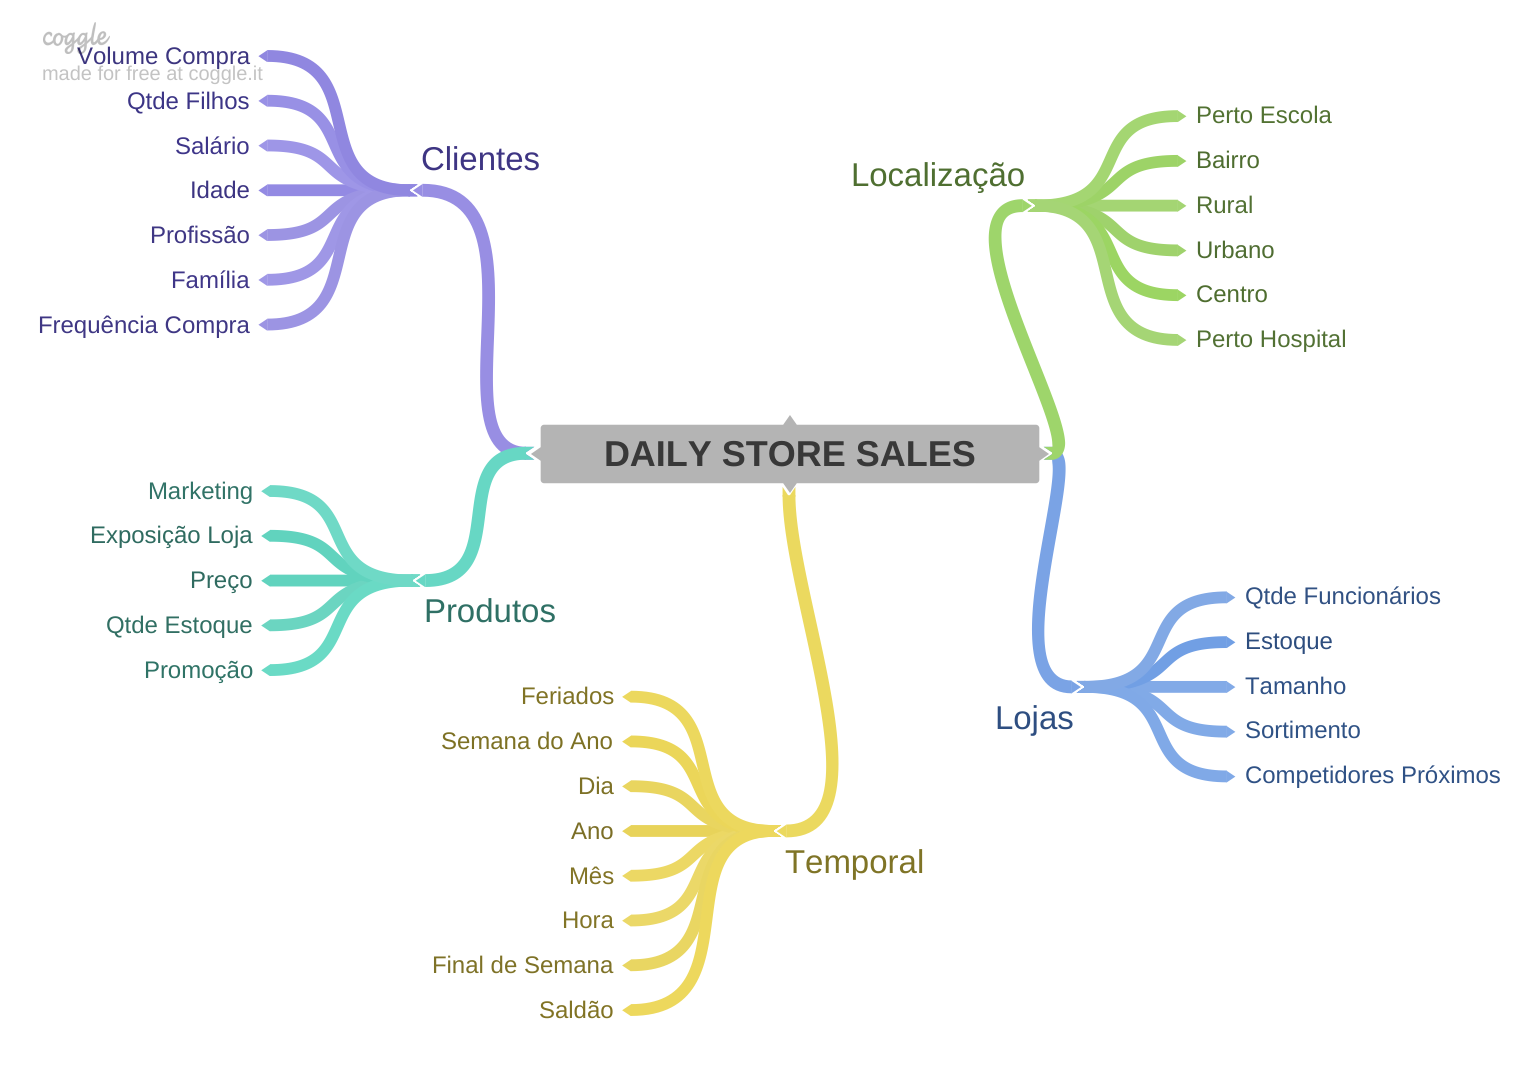

In [3]:
Image('../references/MindMapHypothesis.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Store Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.  
**2.** Lojas com maior capacidade de estoque deveriam vender mais.  
**3.** Lojas com maior porte deveriam vender mais.  
**4.** Lojas com maior sortimento deveriam vender mais.  
**5.** Lojas com competidores mais próximos deveriam vender menos.  
**6.** Lojas com competidores à mais tempo deveriam vendem mais.  

### 2.2.2. Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.  
**2.** Lojas com maior exposição de produto deveriam vender mais.  
**3.** Lojas com produtos com preço menor deveriam vender mais.  
**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.  
**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**7.** Lojas com mais dias de promoção deveriam vender mais.  
**8.** Lojas com mais promoções consecutivas deveriam vender mais.  

### 2.2.3. Time Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**2.** Lojas deveriam vender mais ao longo dos anos.  
**3.** Lojas deveriam vender mais no segundo semestre do ano.  
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**5.** Lojas deveriam vender menos aos finais de semana.  
**6.** Lojas deveriam vender menos durante os feriados escolares.  

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.  
**2.** Lojas com competidores mais próximos deveriam vender menos.  
**3.** Lojas com competidores à mais tempo deveriam vendem mais.  
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**5.** Lojas com mais dias de promoção deveriam vender mais.  
**7.** Lojas com mais promoções consecutivas deveriam vender mais.  
**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.  
**9.** Lojas deveriam vender mais ao longo dos anos.  
**10.** Lojas deveriam vender mais no segundo semestre do ano.  
**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.  
**12.** Lojas deveriam vender menos aos finais de semana.  
**13.** Lojas deveriam vender menos durante os feriados escolares.  

## 2.4. Engenharia de Variáveis

In [4]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), axis=1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                                    datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                  'easter_holiday' if x == 'b' else 
                                                  'christmas' if x == 'c' else 'regular_day')

In [5]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [6]:
# Salvando modificações para carregar na próxima etapa
df2.to_csv('../data/interim/df_step02.csv', index=False)

# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [7]:
# Carregando dados tratados da etapa anterior
df3 = pd.read_csv('../data/interim/df_step02.csv', low_memory=False, parse_dates=['date'])

In [9]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem de Linhas

In [10]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem de Colunas

In [11]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [12]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [13]:
# Salvando modificações para carregar na próxima etapa
df3.to_csv('../data/interim/df_step03.csv', index=False)

# 4.0. PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [4]:
# Carregando dados tratados da etapa anterior
df4 = pd.read_csv('../data/interim/df_step03.csv', low_memory=False, parse_dates=['date'])

## 4.1. Análise Univariada

### 4.1.1. Variável Resposta

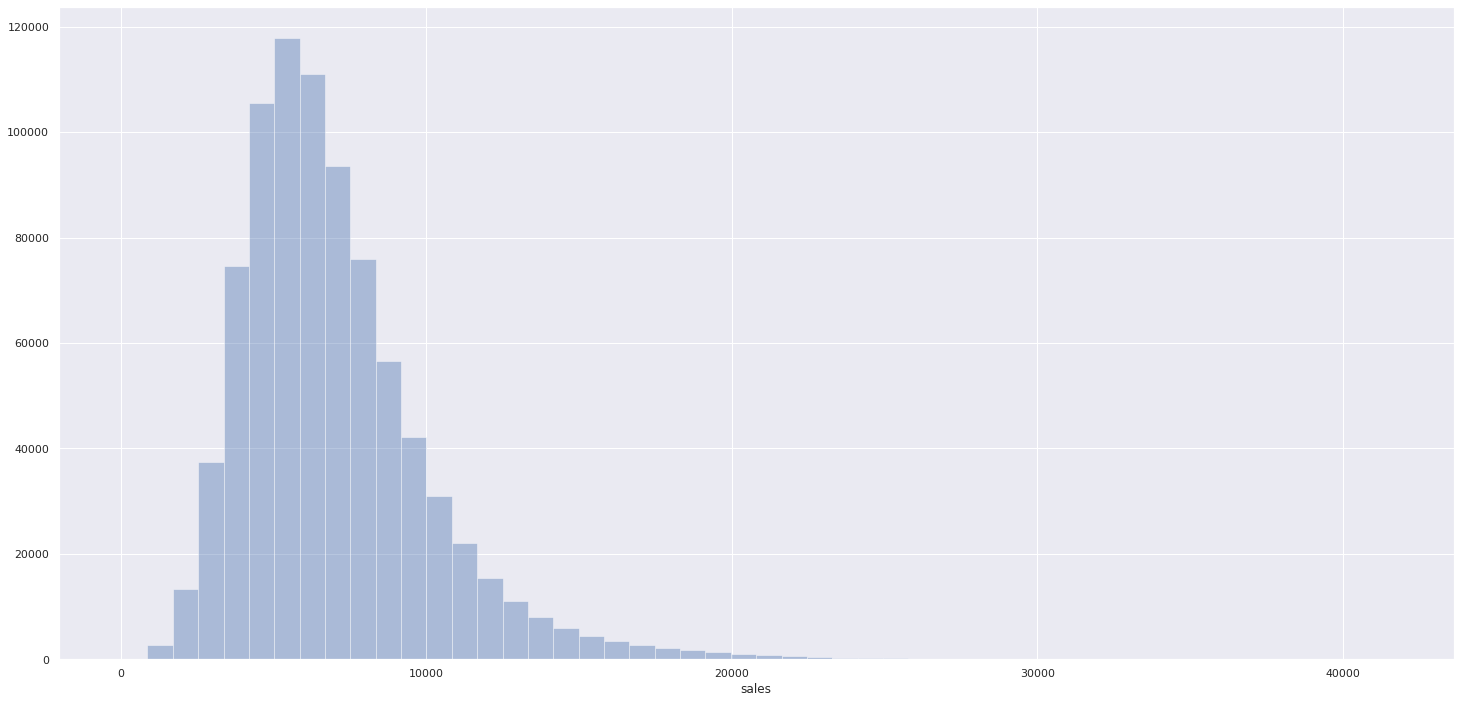

In [5]:
sns.distplot(df4['sales'], kde=False);

### 4.1.2. Variáveis Numéricas

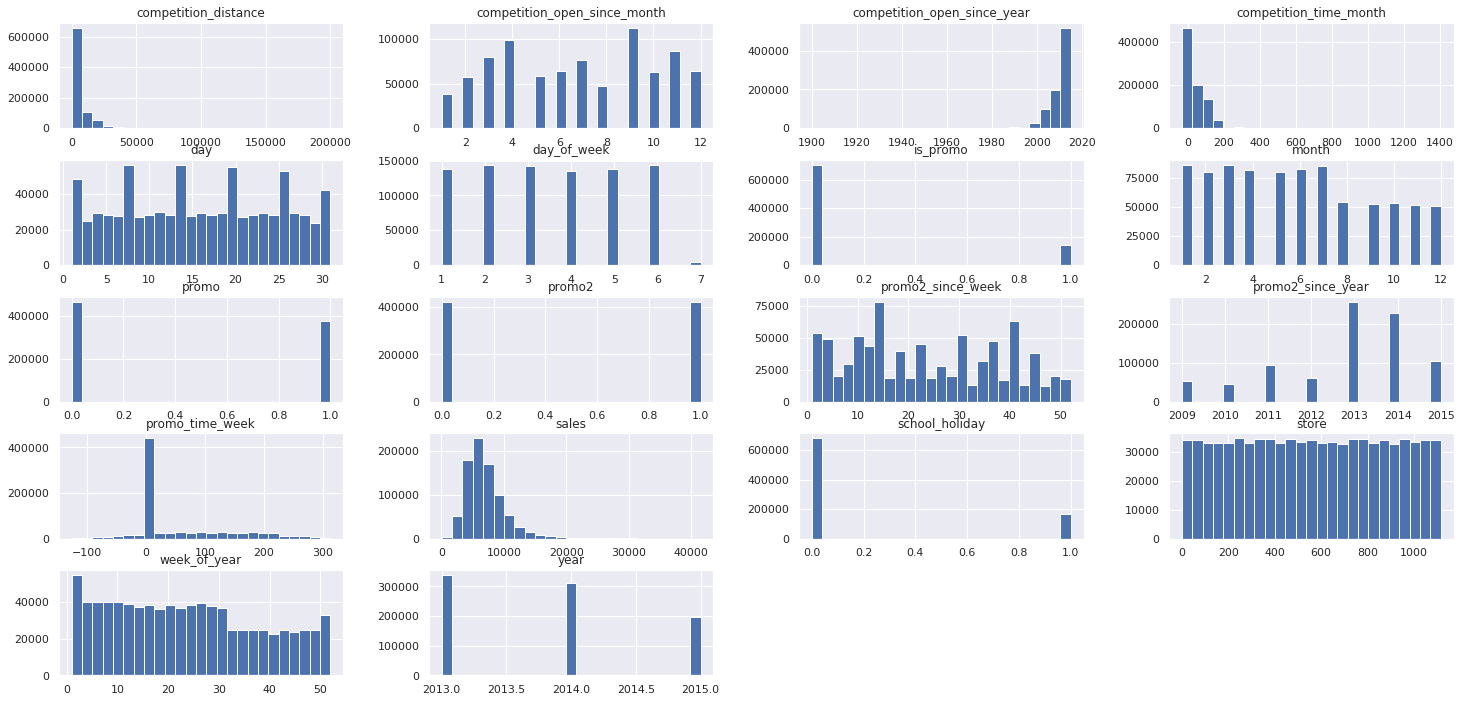

In [6]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
num_attributes.hist(bins=25);

### 4.1.3. Variáveis Categóricas

In [7]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

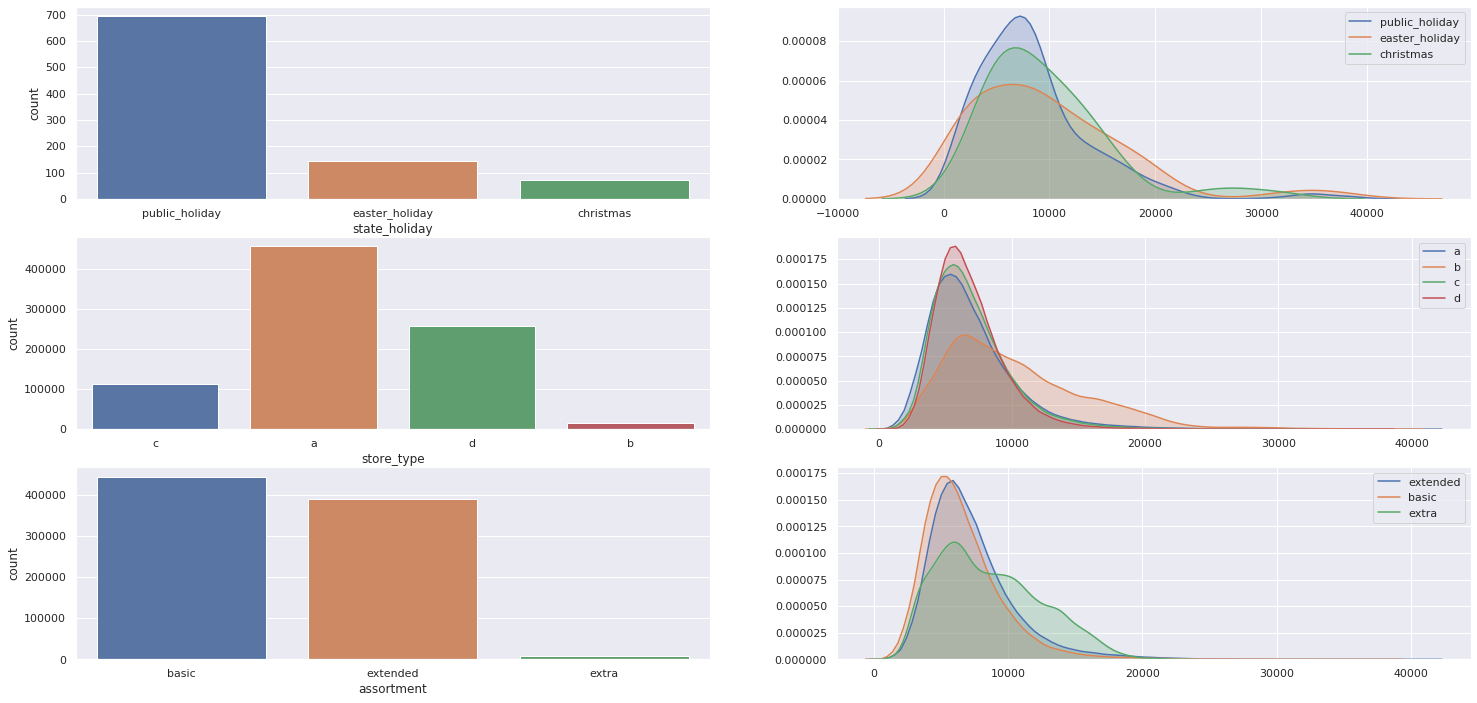

In [8]:
# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

# store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type']);

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

# assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment']);

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Análise Bi-variada

### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem MENOS.

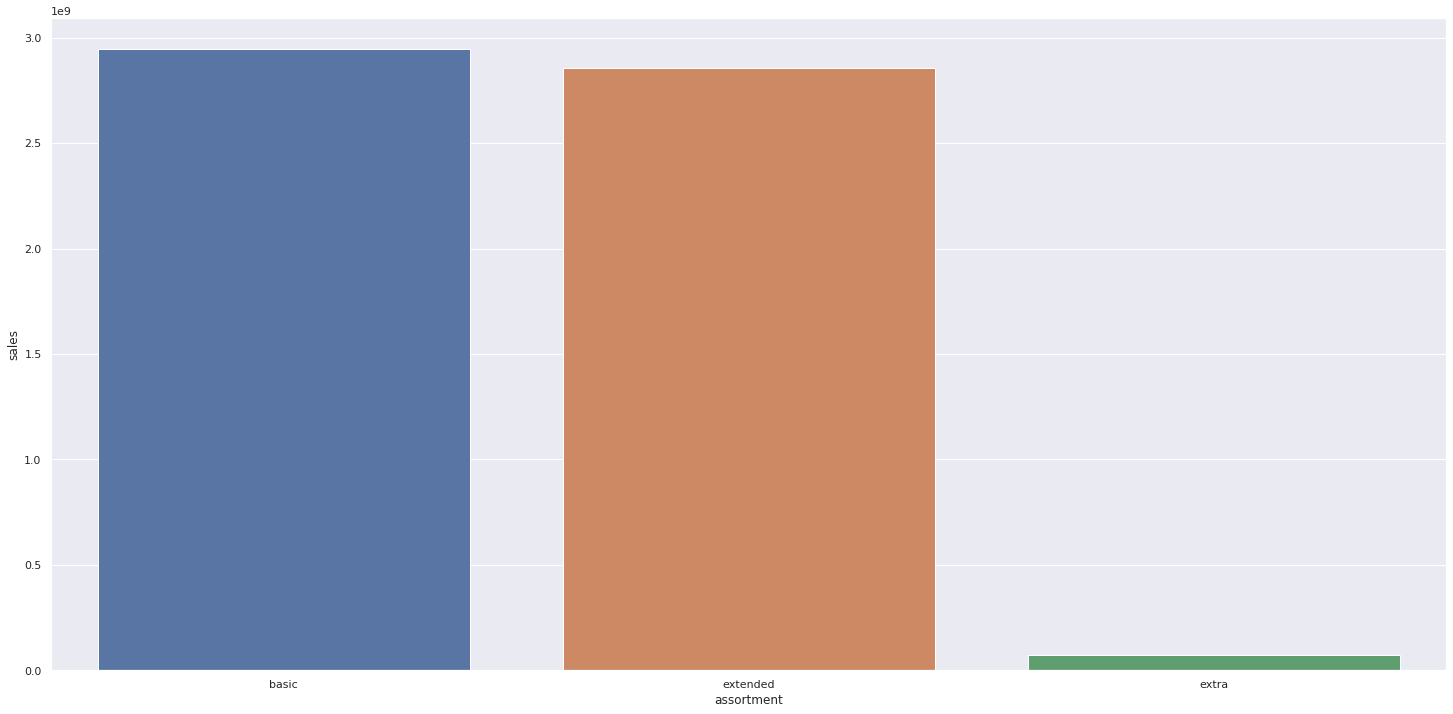

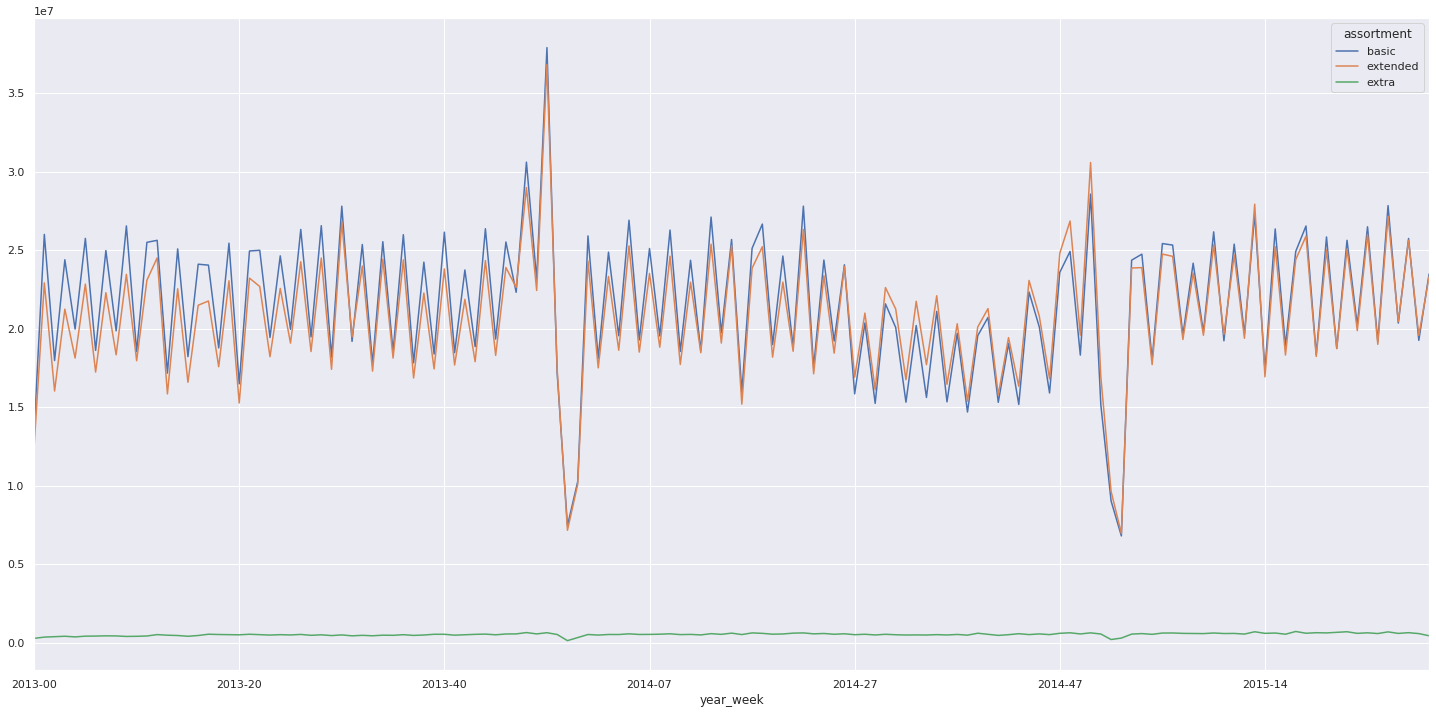

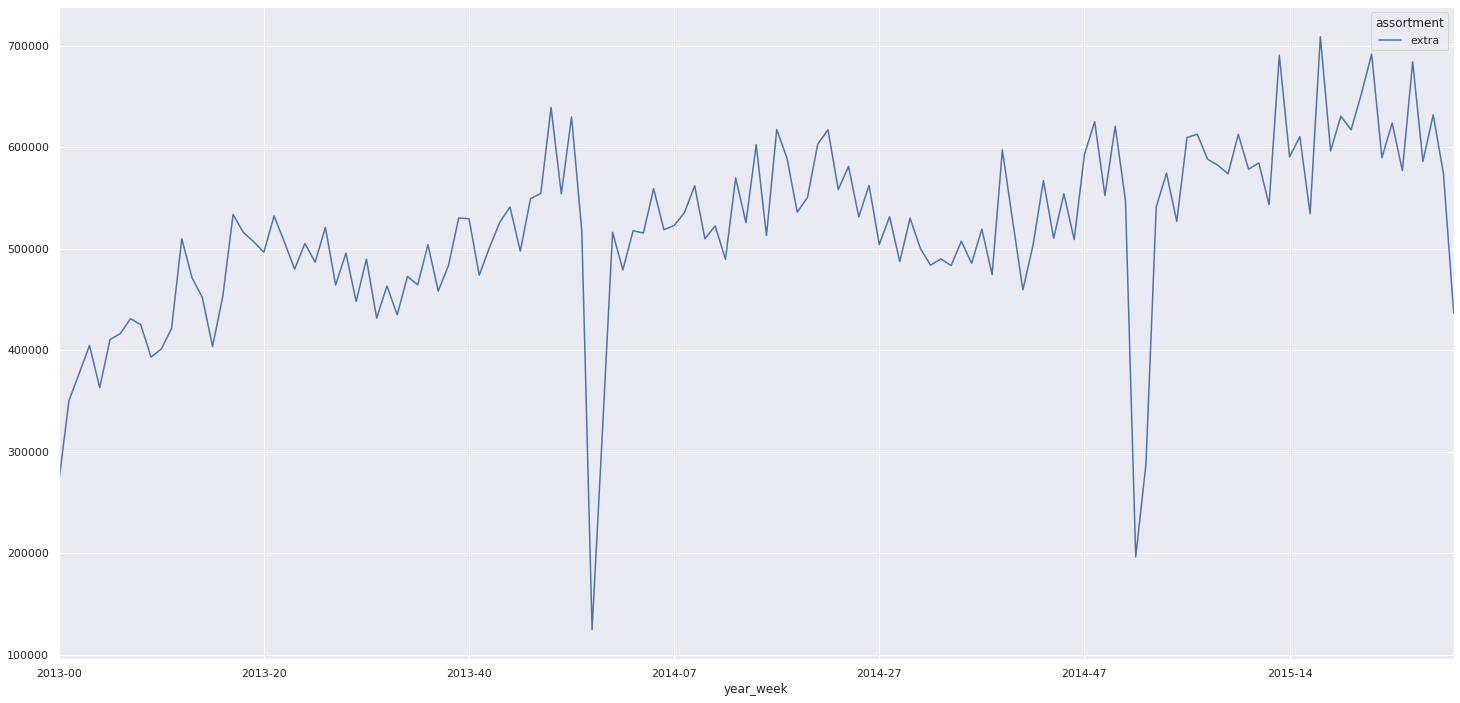

In [9]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS.

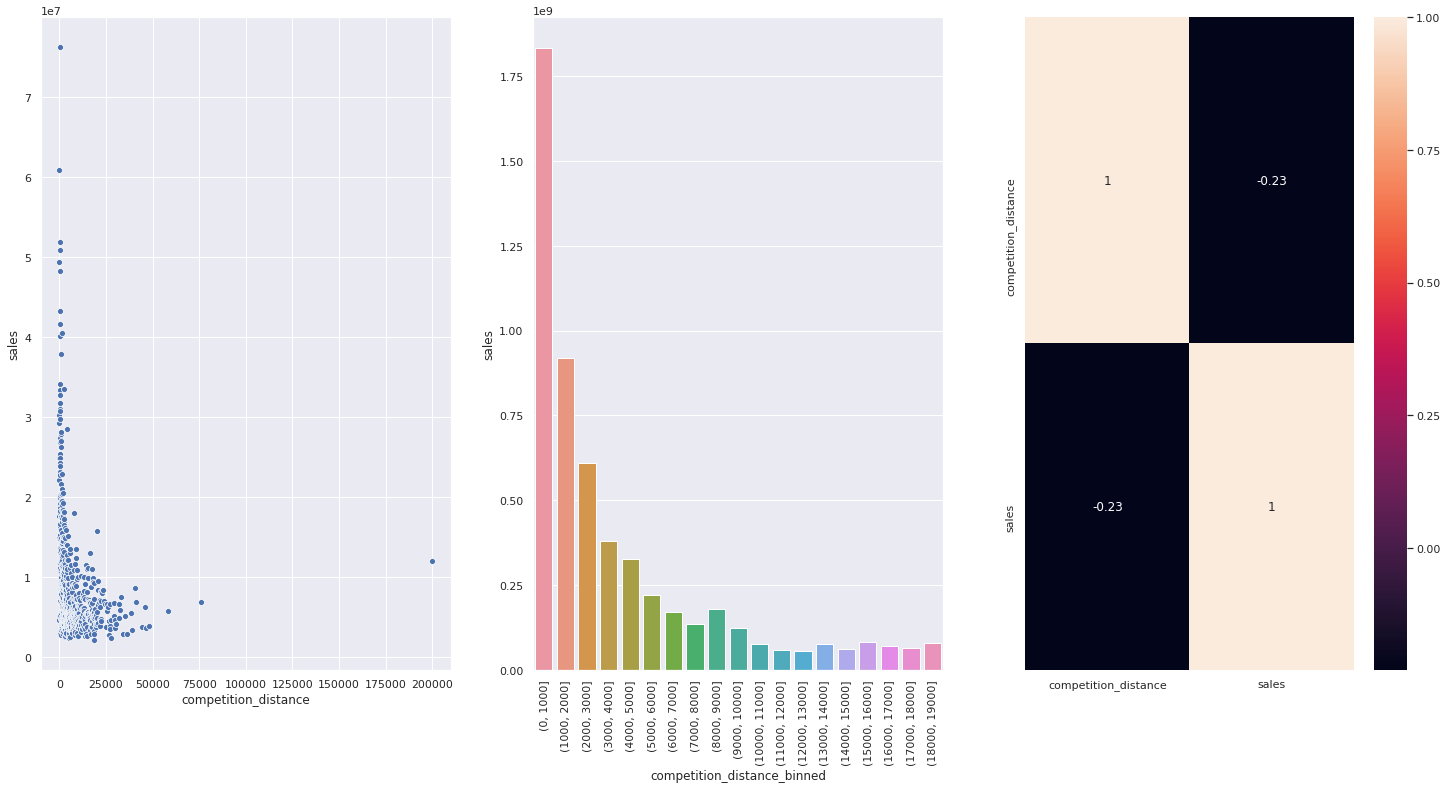

In [10]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

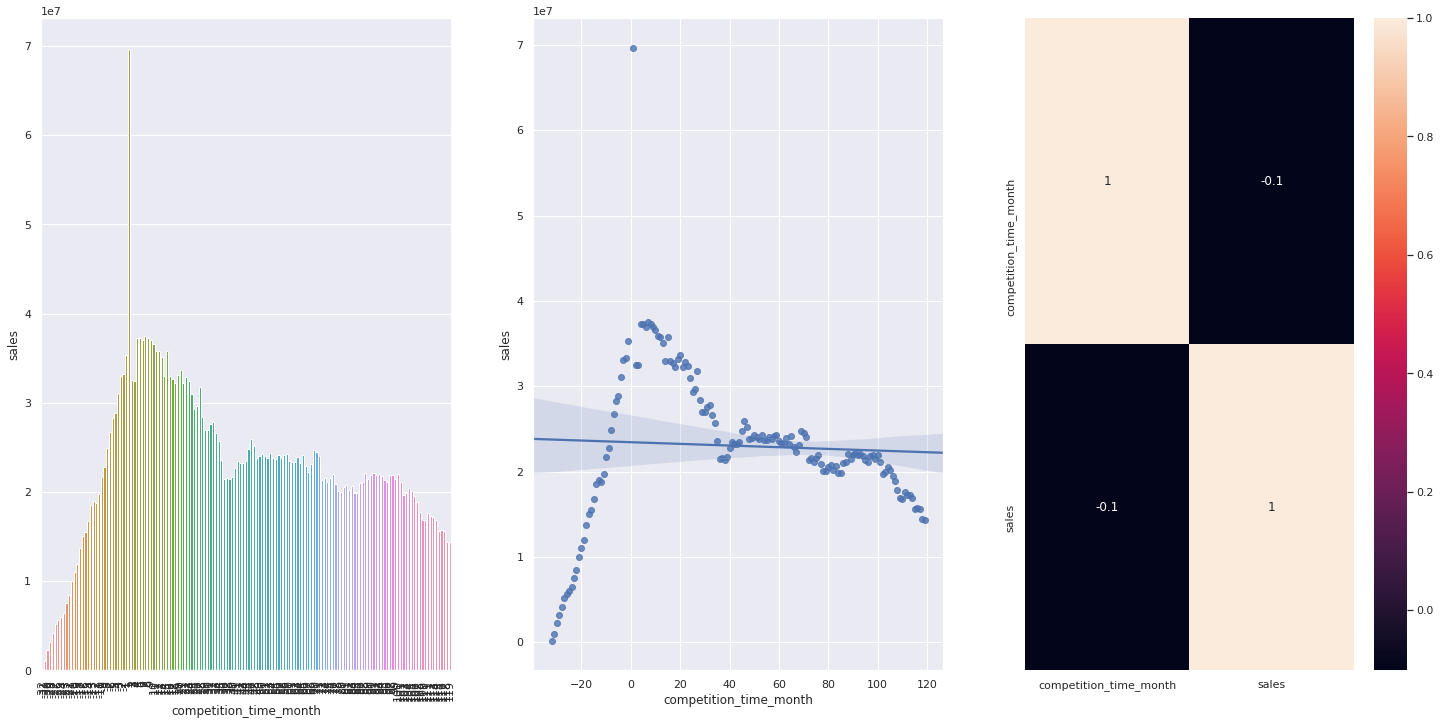

In [11]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# filtro para diminuir granularidade
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos depois de um certo período de promoção.

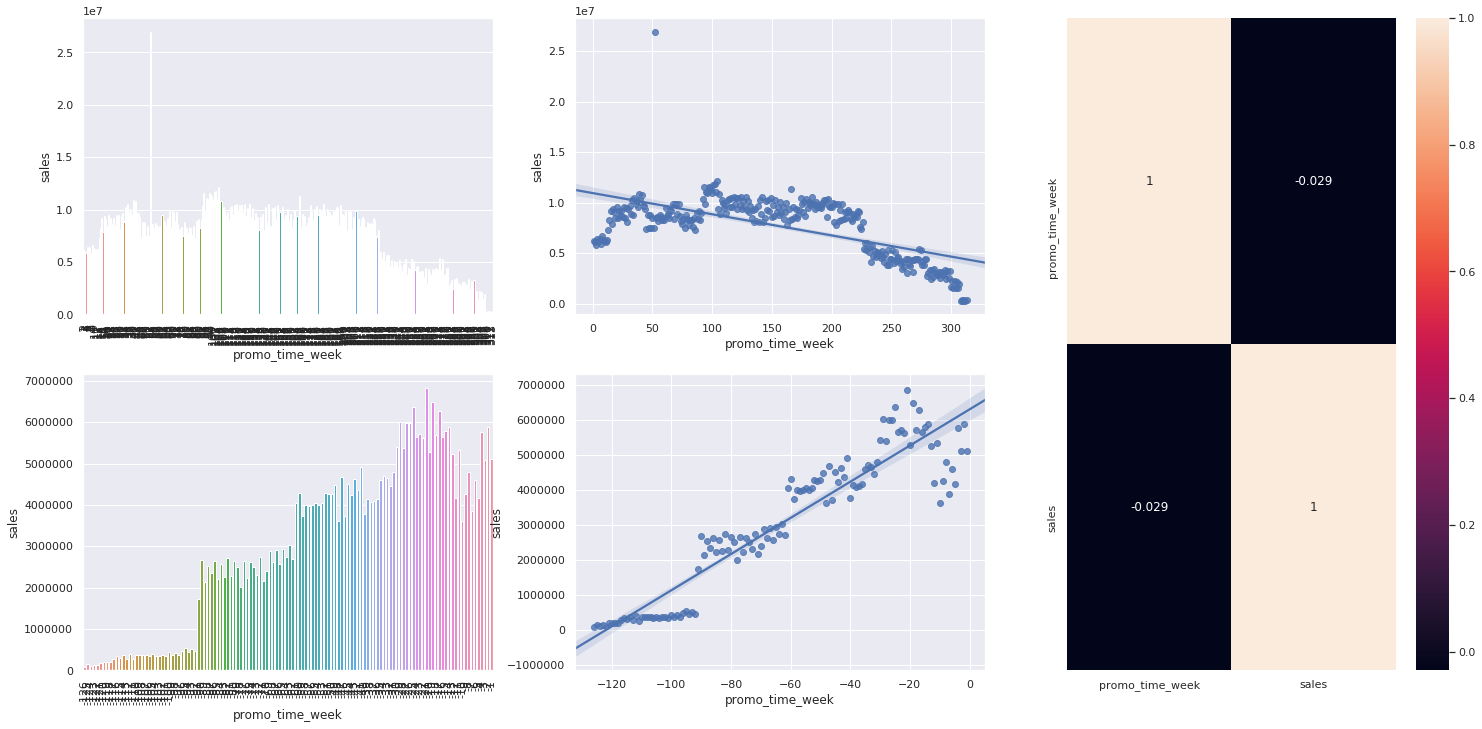

In [12]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo estendida
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo estendida
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo normal
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo normal
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

On hold. Validar no próximo ciclo, pois exige outros tratamentos nas variáveis.

### H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [13]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales').reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


Aparentemente lojas que participaram da promoção estendida vendeu menos do que as que participaram apenas da primeira promoção.  
Será que houve alguma mudança de comportamento ao longo do tempo?

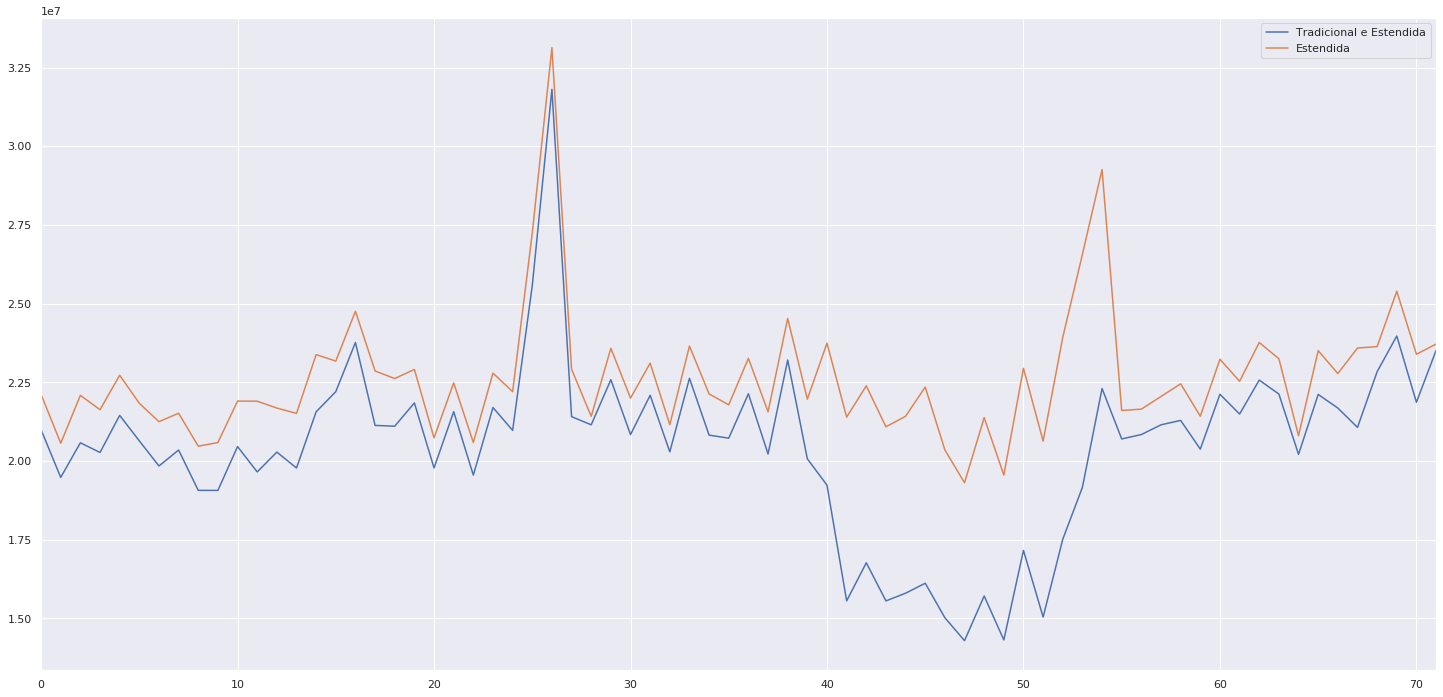

In [14]:
# lojas que aderiram as duas promoções
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# lojas que aderiram somente a promoção normal
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Estendida', 'Estendida']);

O comportamento das vendas durantes as promoções é similar, tendo apenas uma região pontual de comportamento diferente entre as duas categorias. Logo, essa pode ser uma variável irrelevante para o modelo.

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

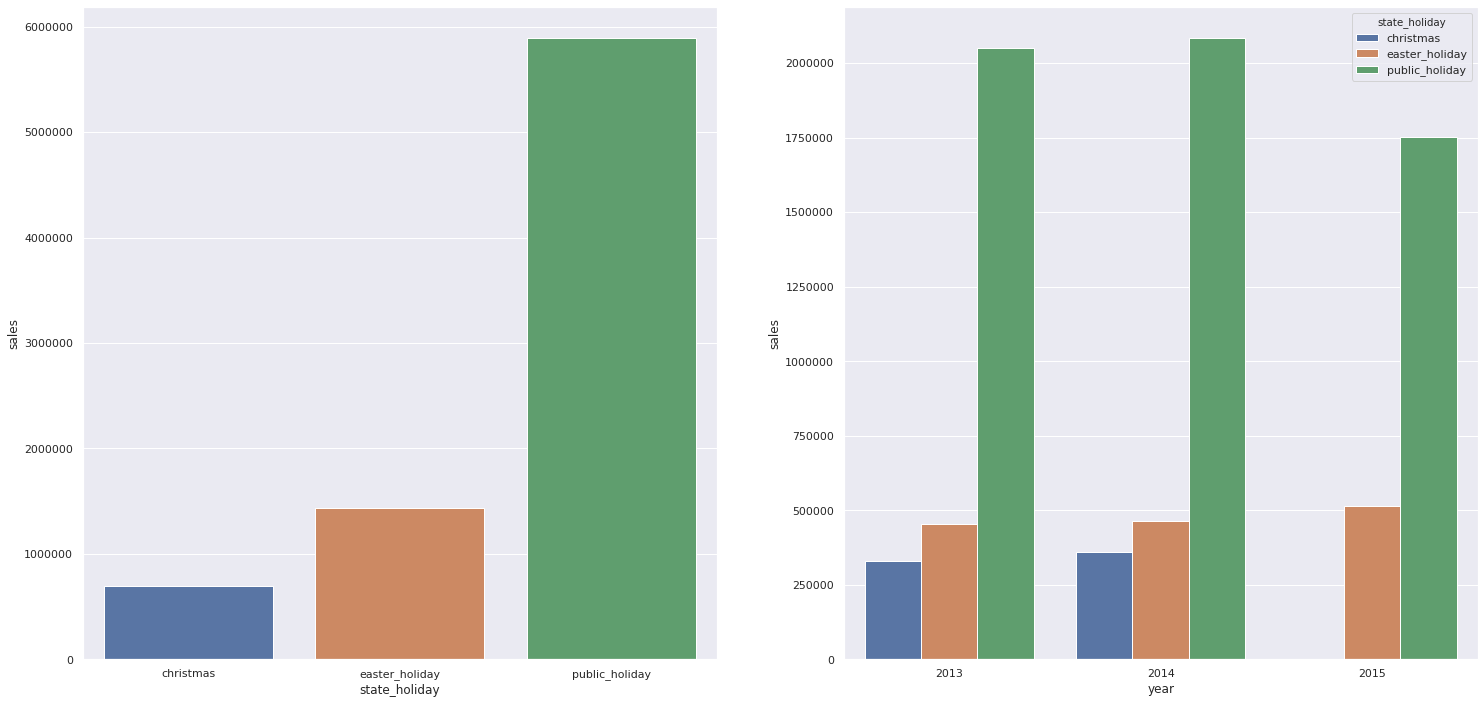

In [15]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos.

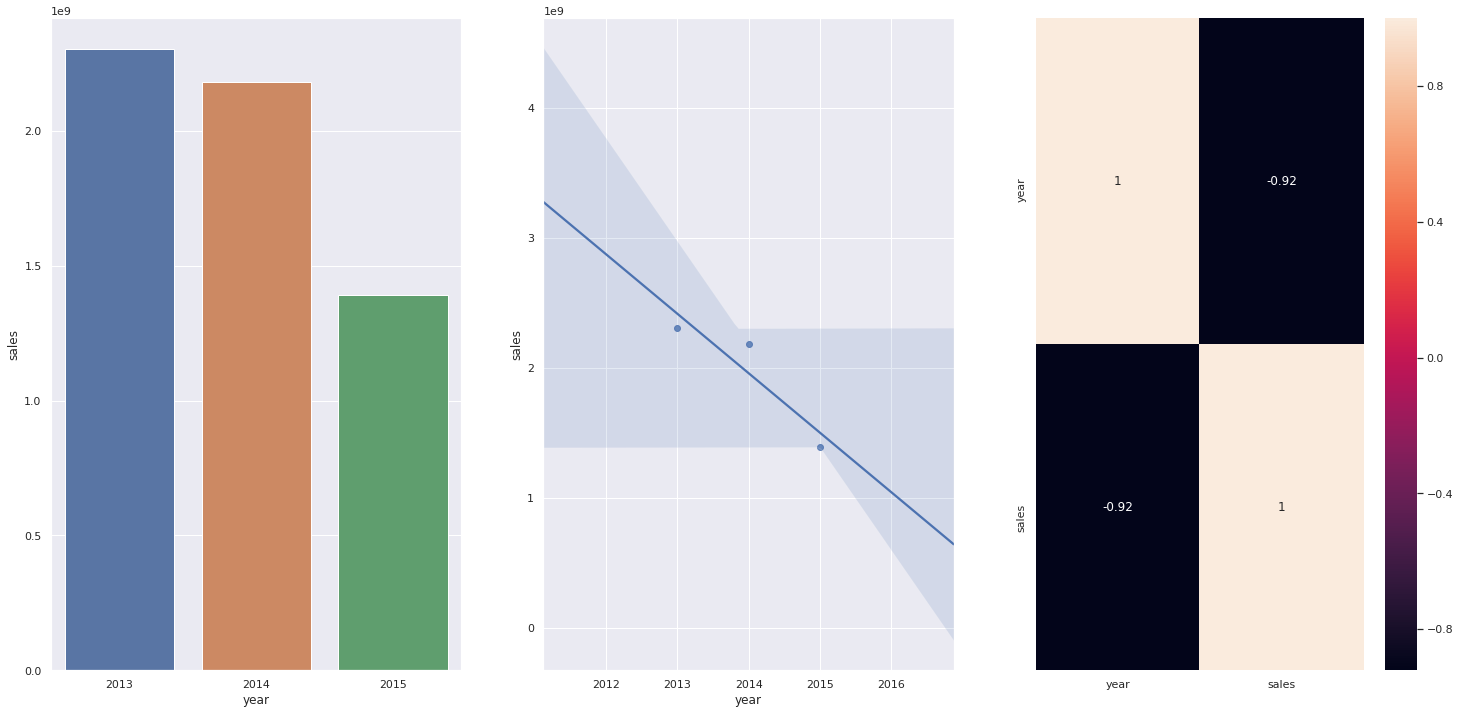

In [16]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Há uma forte correlação negativa que indica queda de venda ao longo dos anos. Porém, 2015 não está completo nesse dataset.  
Com isso, sempre analisar períodos fechados. No entanto, já é possível observar que essa variável pode ser relevante para o modelo.

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano.

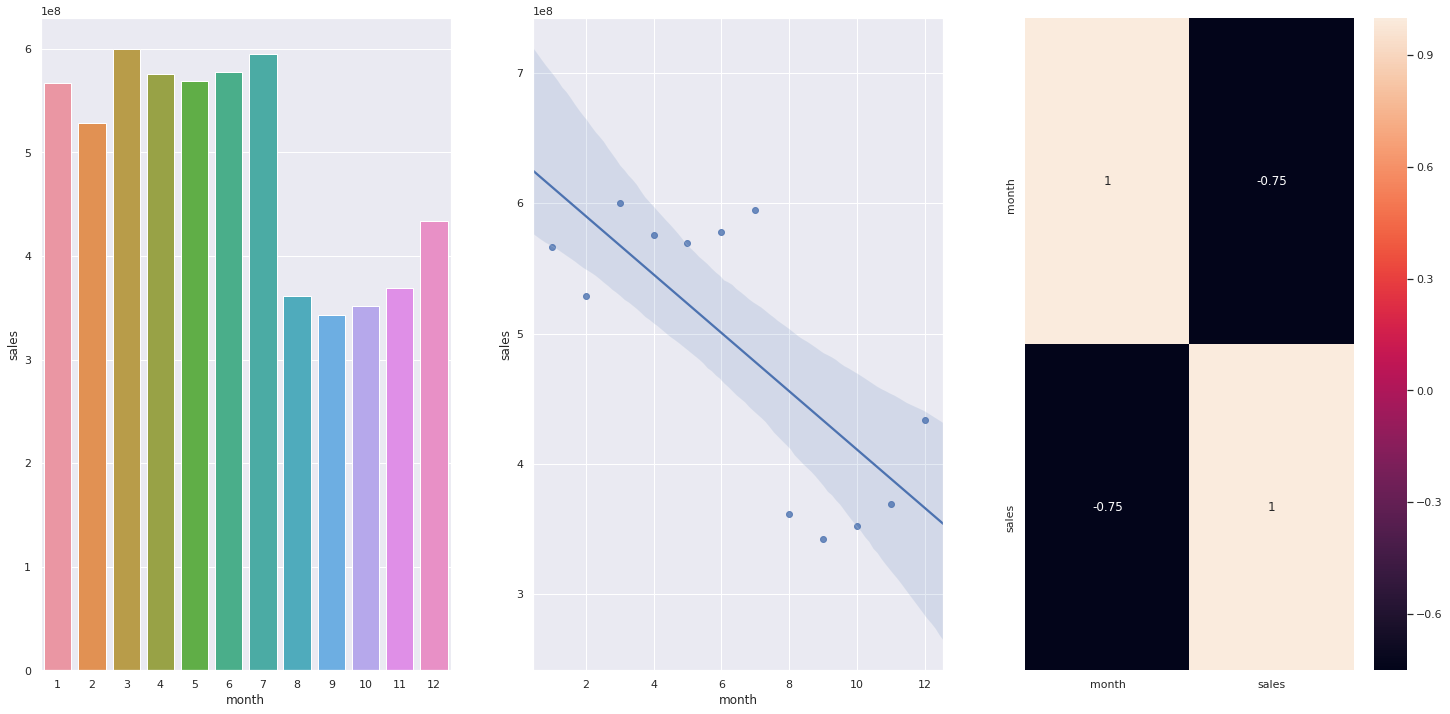

In [17]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10.

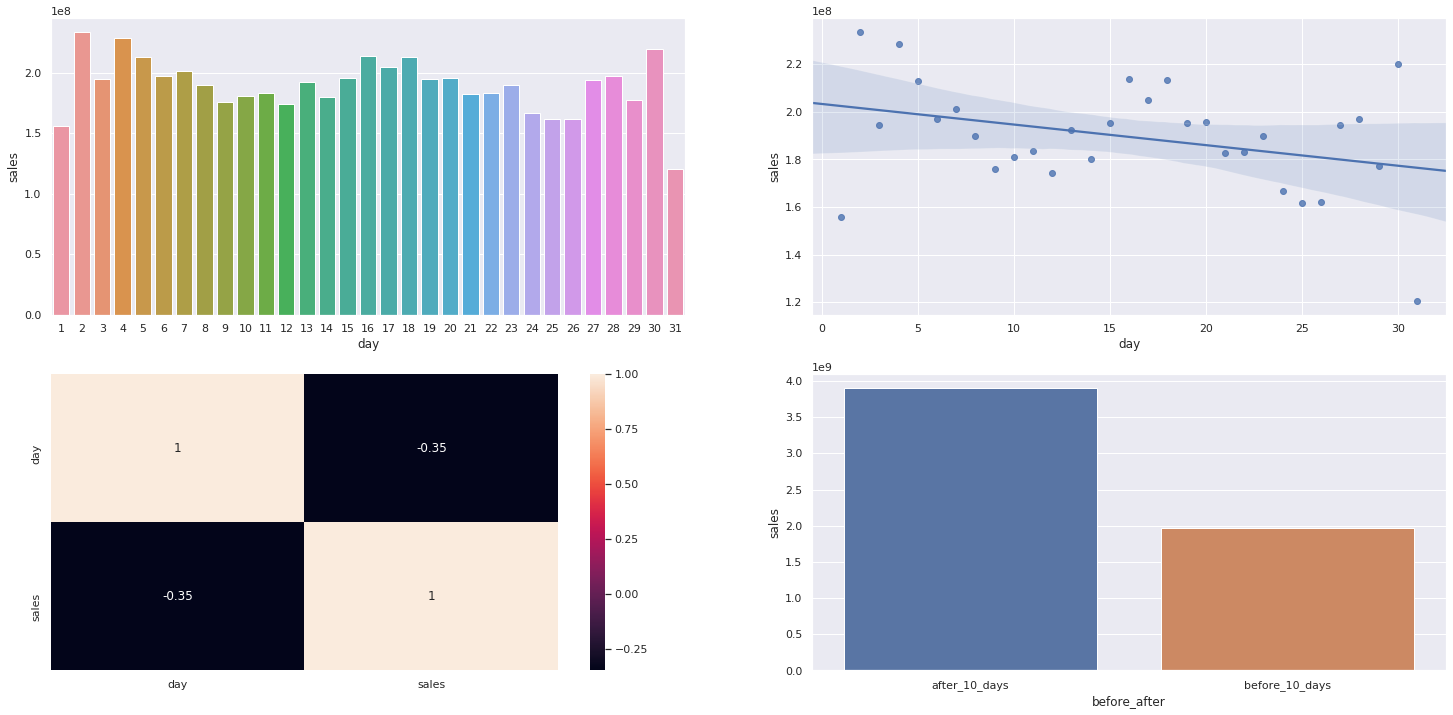

In [18]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

Uma observação é que a categoria após 10 dias é maior do que o alvo de até 10 dias, logo não é uma comparação justa.

### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos aos finais de semana.

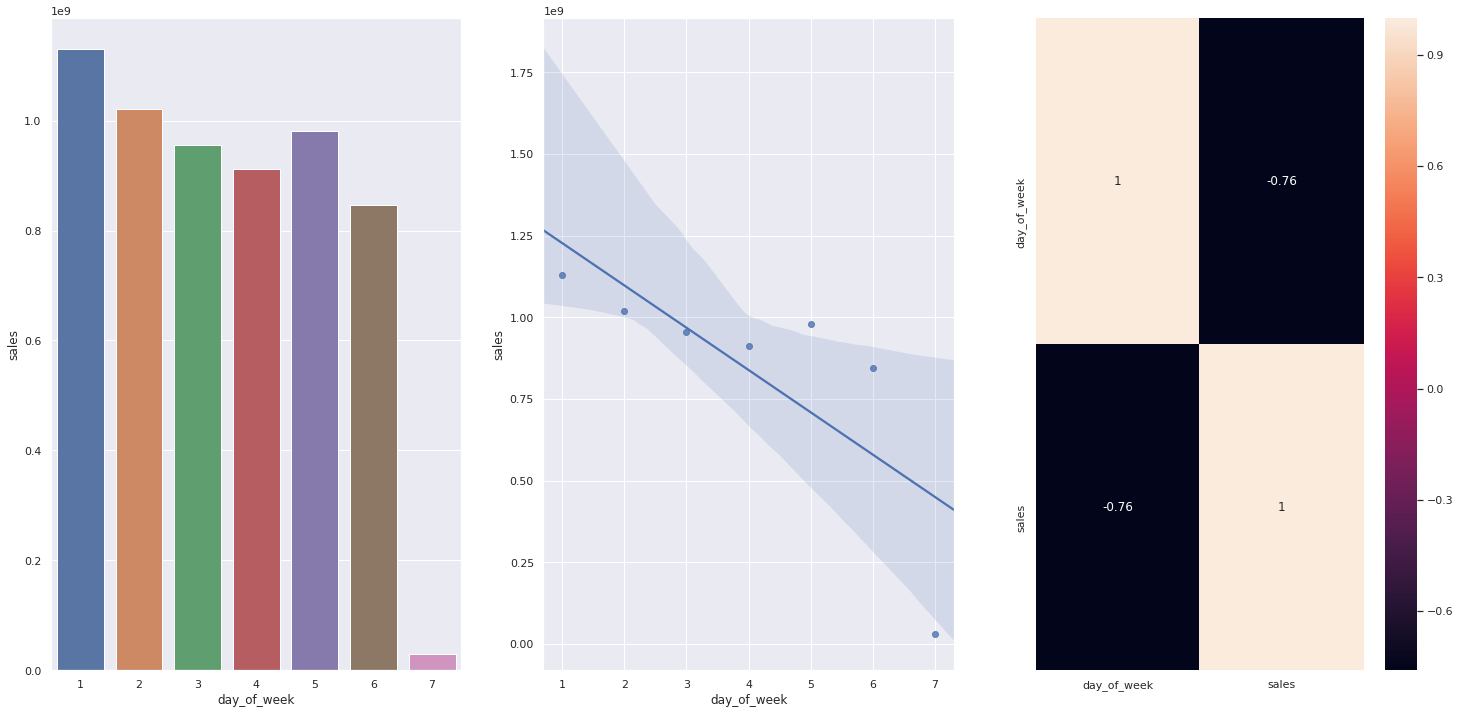

In [19]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto nos meses de julho e agosto.

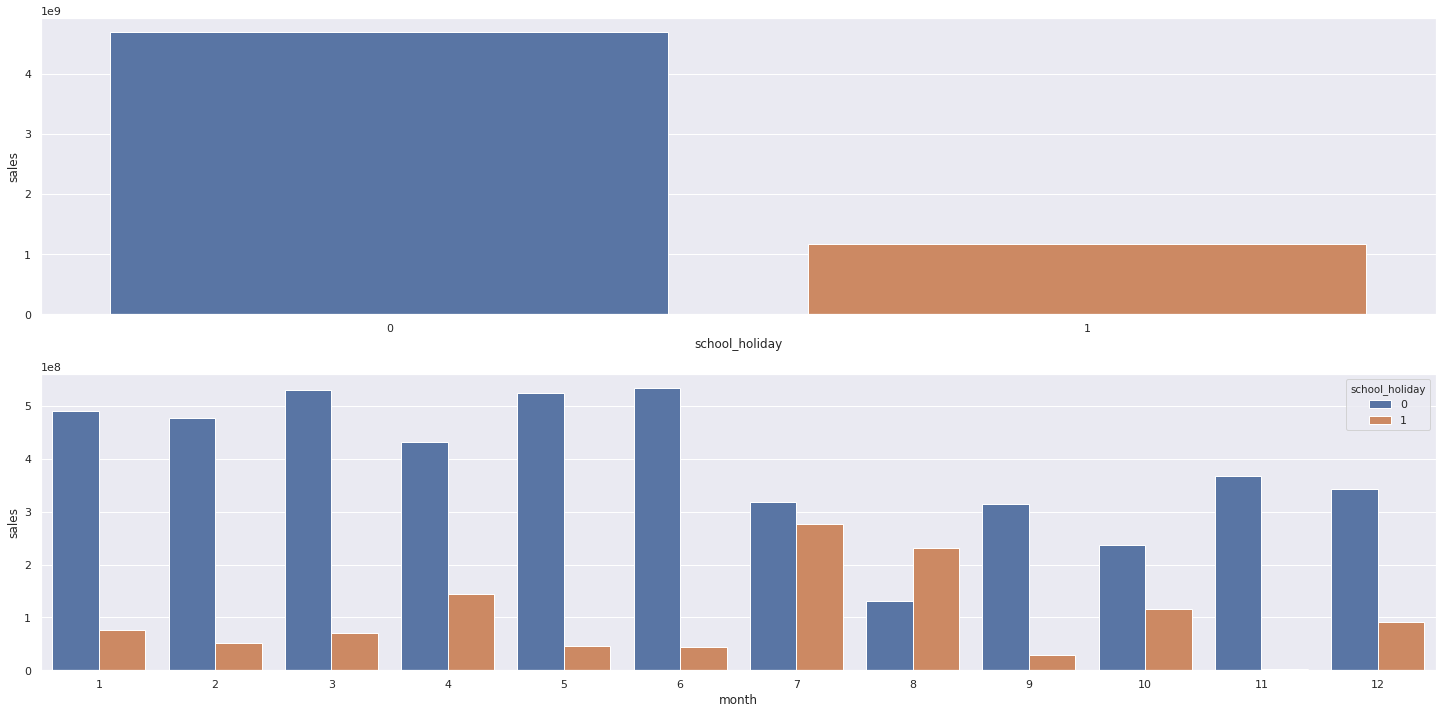

In [20]:
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1)

plt.subplot(2, 1, 2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipóteses

In [21]:
tab = [
    ['Hipoteses', 'Conclusao', 'Relevancia'],
    ['H1', 'Falsa', 'Baixa'],
    ['H2', 'Falsa', 'Media'],
    ['H3', 'Falsa', 'Media'],
    ['H4', 'Falsa', 'Baixa'],
    ['H5', '-', '-'],
    ['H7', 'Falsa', 'Baixa'],
    ['H8', 'Falsa', 'Media'],
    ['H9', 'Falsa', 'Alta'],
    ['H10', 'Falsa', 'Alta'],
    ['H11', 'Verdadeira', 'Alta'],
    ['H12', 'Verdadeira', 'Alta'],
    ['H13', 'Verdadeira', 'Baixa']
]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Análise Multivariada

### 4.3.1 Variáveis Numéricas

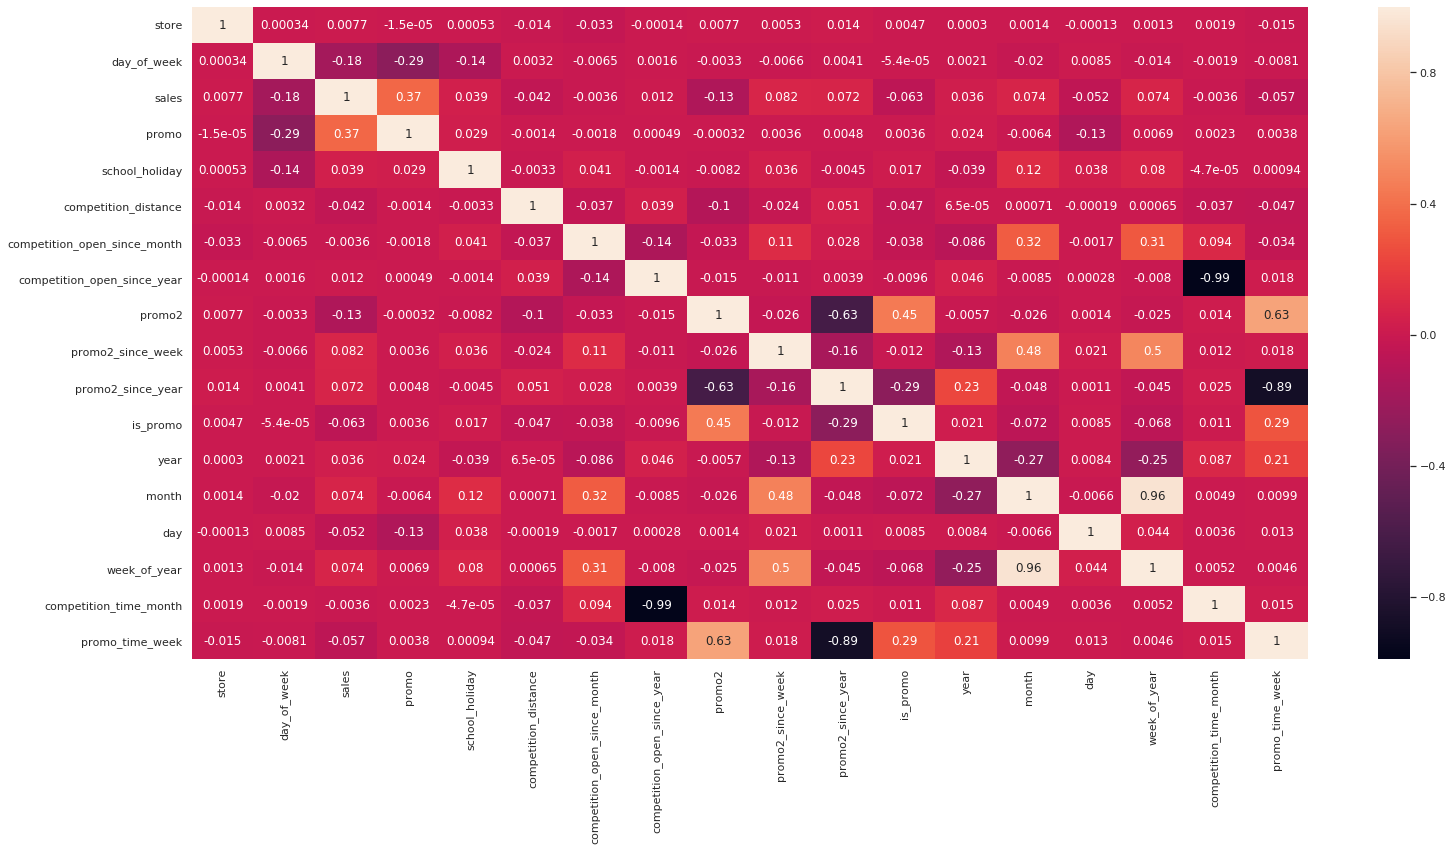

In [22]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Variáveis Categóricas

<ipython-input-2-773fd4547c5f>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x, y).as_matrix()


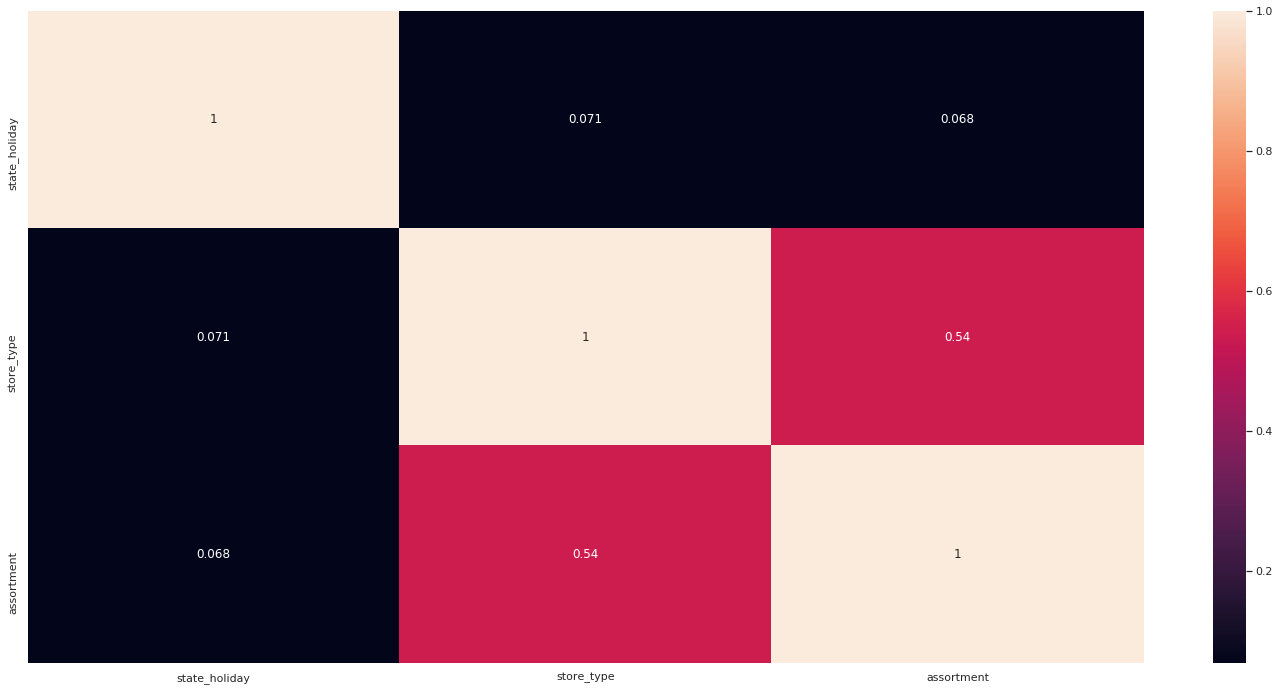

In [23]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

# resultado do V de Cramer de todas as combinações
a1 = cramer_v(cat_attributes['state_holiday'], cat_attributes['state_holiday'])
a2 = cramer_v(cat_attributes['state_holiday'], cat_attributes['store_type']) 
a3 = cramer_v(cat_attributes['state_holiday'], cat_attributes['assortment'])

a4 = cramer_v(cat_attributes['store_type'], cat_attributes['state_holiday'])
a5 = cramer_v(cat_attributes['store_type'], cat_attributes['store_type']) 
a6 = cramer_v(cat_attributes['store_type'], cat_attributes['assortment'])

a7 = cramer_v(cat_attributes['assortment'], cat_attributes['state_holiday'])
a8 = cramer_v(cat_attributes['assortment'], cat_attributes['store_type'])
a9 = cramer_v(cat_attributes['assortment'], cat_attributes['assortment'])

# dataframe com os resultados
d = pd.DataFrame({
    'state_holiday': [a1, a2, a3],
    'store_type': [a4, a5, a6],
    'assortment': [a7, a8, a9]
})
d = d.set_index(d.columns)

# correlação
sns.heatmap(d, annot=True);

In [24]:
# Salvando modificações para carregar na próxima etapa
df4.to_csv('../data/interim/df_step04.csv', index=False)

# 5.0. PASSO 05 - PREPARAÇÃO DOS DADOS

In [5]:
# Carregando dados tratados da etapa anterior
df5 = pd.read_csv('../data/interim/df_step04.csv', low_memory=False, parse_dates=['date'])

## 5.1. Normalização

Olhando a análise exploratória univariada, vimos que não temos nenhuma variável com distribuição normal. Com isso, não iremos realizar o processo de normalização, pois ele é aplicado e funciona muito bem quando temos distribuições normais (gaussianas).

## 5.2. Redimensionamento (Rescaling)

In [6]:
num_att = df5.select_dtypes(include=['int64', 'float64'])

In [14]:
num_att.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


Variáveis selecionadas para rescaling:
- competition_distance
- competition_time_month
- promo_time_week
- year

- **Checando outliers**

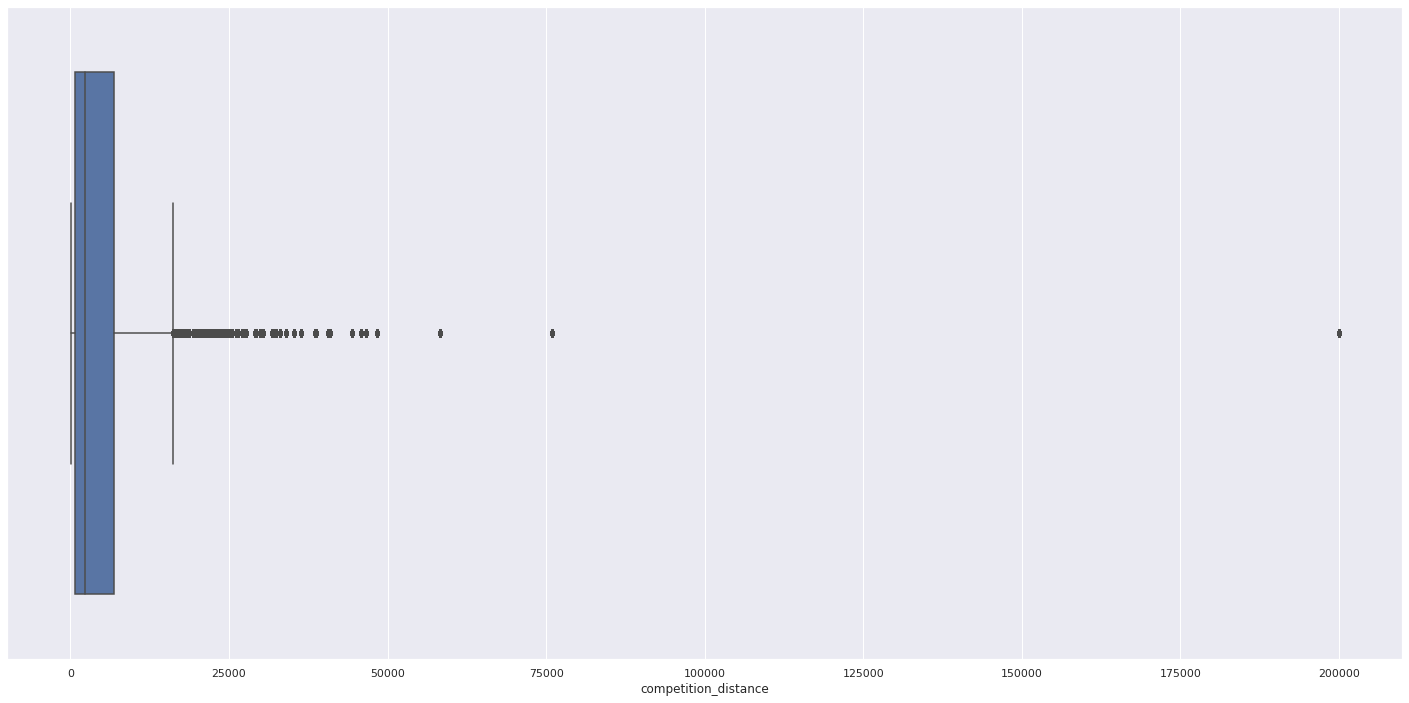

In [15]:
sns.boxplot(df5['competition_distance']);

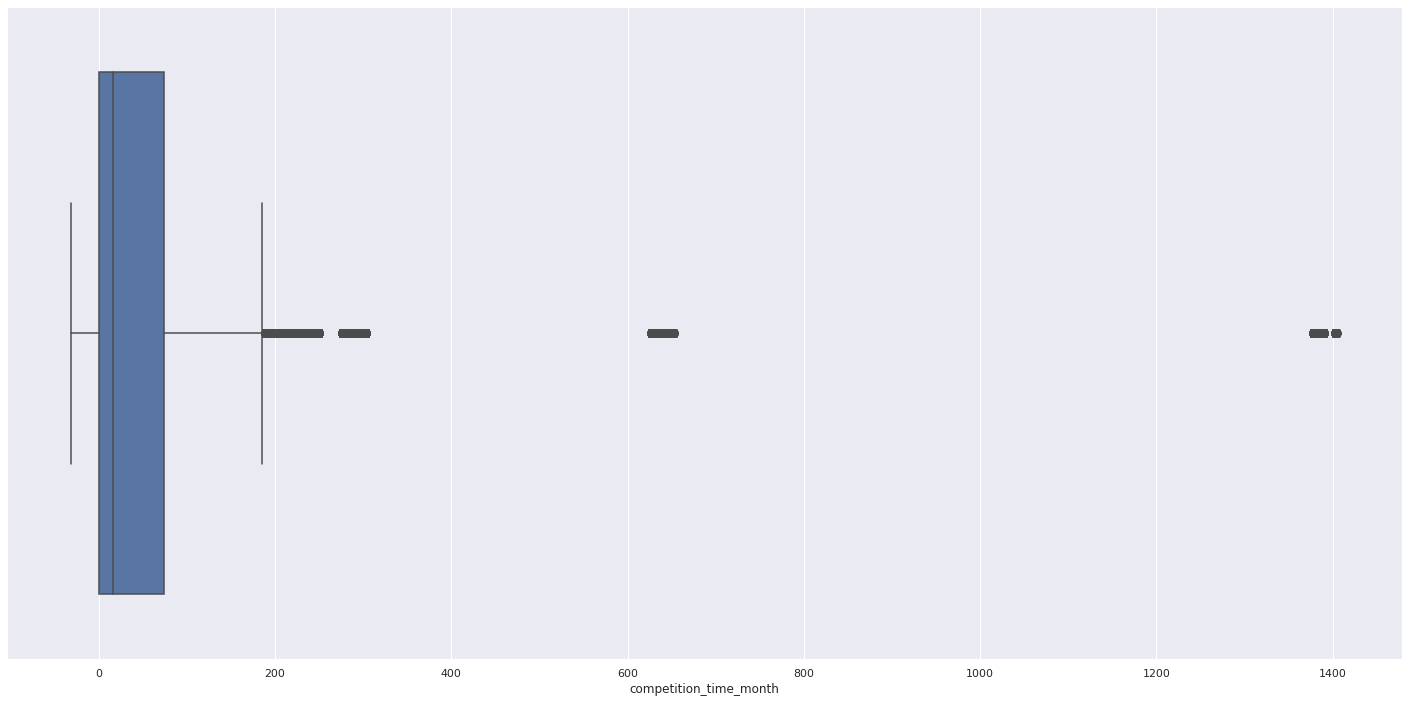

In [16]:
sns.boxplot(df5['competition_time_month']);

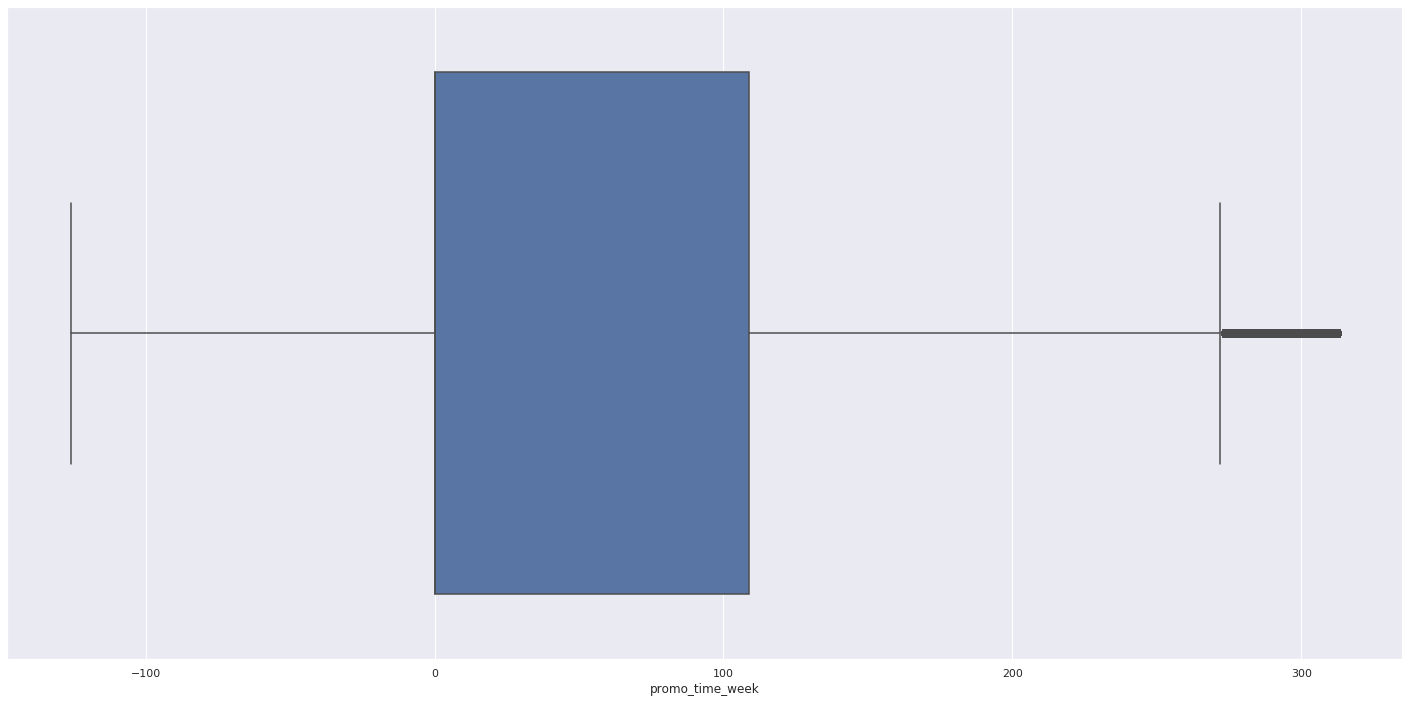

In [17]:
sns.boxplot(df5['promo_time_week']);

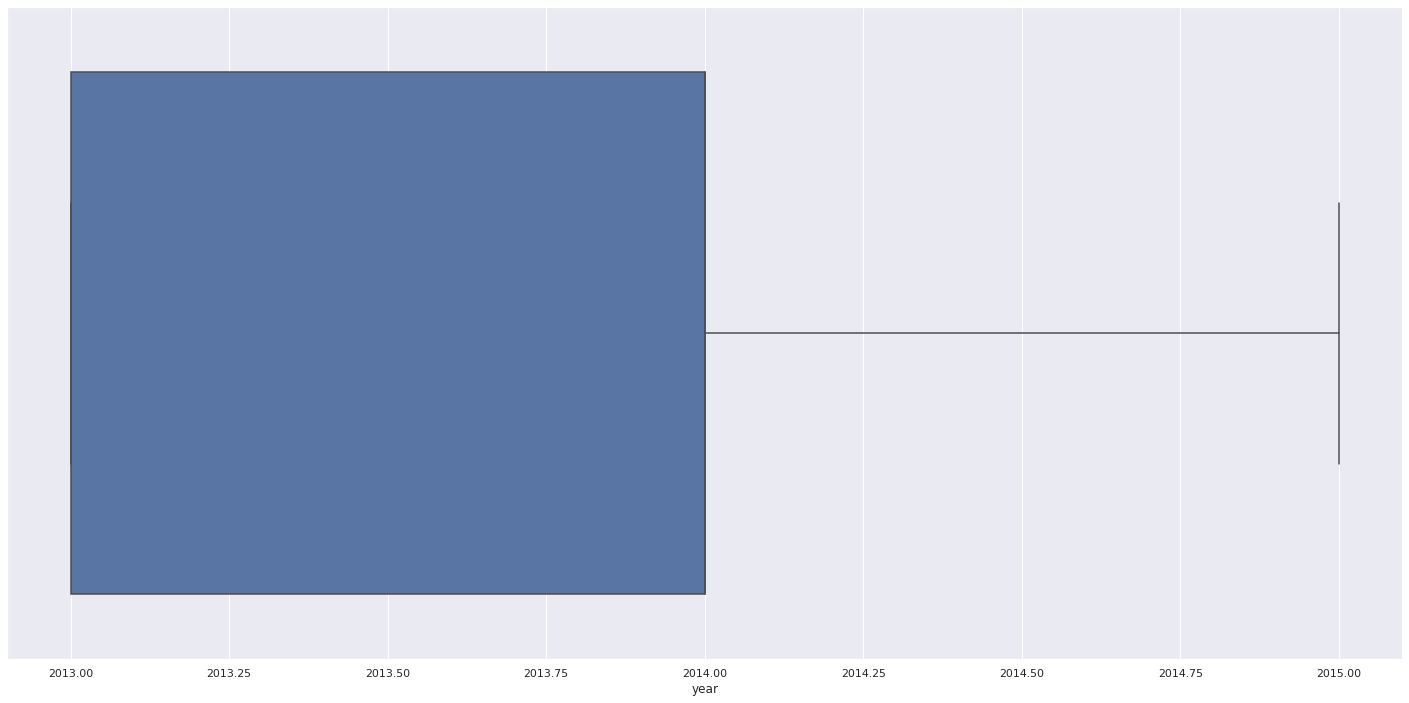

In [18]:
sns.boxplot(df5['year']);

In [7]:
rs = RobustScaler()  # para variável com outlier
mms = MinMaxScaler() # para variável sem outlier ou outlier irrelevante

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
# salvando para aplicar na classe
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
# salvando para aplicar na classe
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
# salvando para aplicar na classe
pickle.dump(rs, open('../parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformação

### 5.3.1. Enconding

In [8]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# salvando para aplicar na classe
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

# assortment - Ordinal Encoding
assortment_dict = {
    'basic': 1, 'extra': 2, 'extended': 3
}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação da Variável Resposta

In [20]:
# transformação logarítmica
df5['sales'] = np.log1p(df5['sales'])

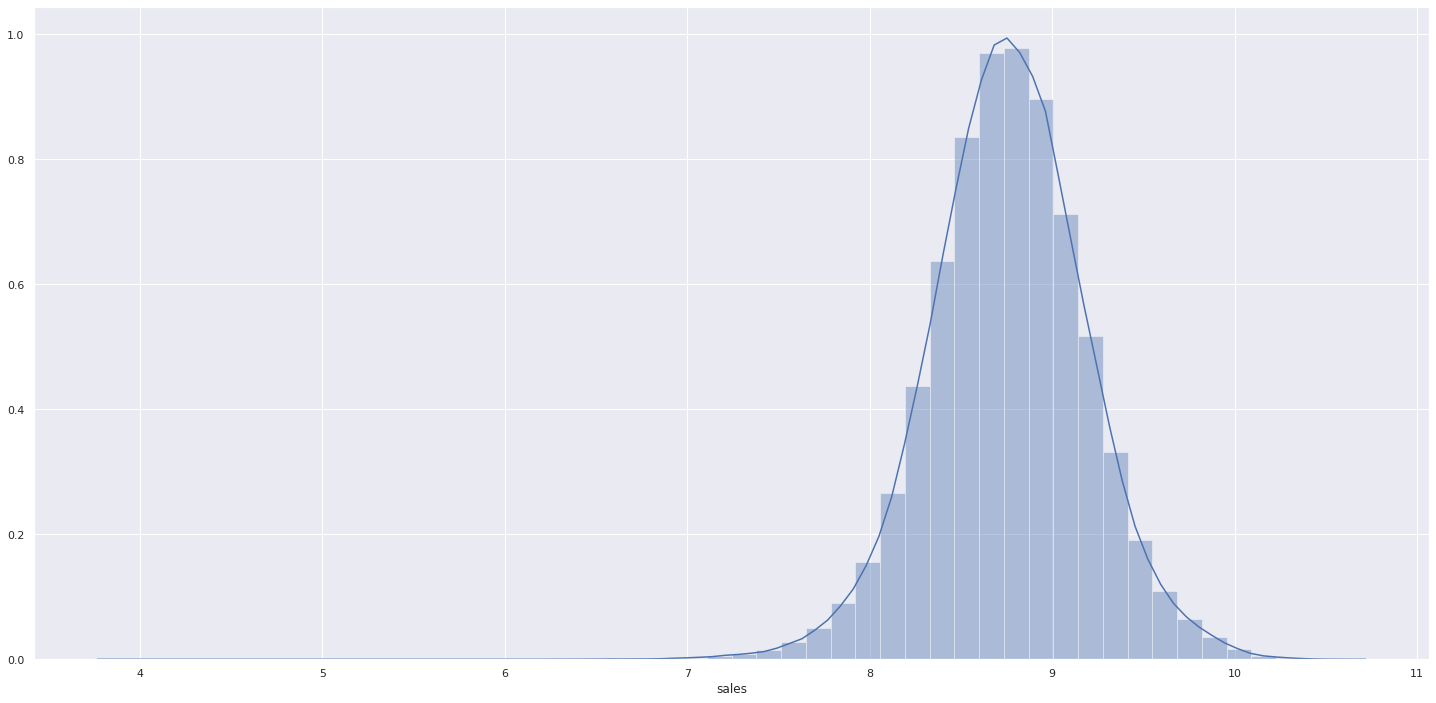

In [21]:
sns.distplot(df5['sales']);

### 5.3.3. Transformação de Natureza

In [23]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [24]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [25]:
# Salvando modificações para carregar na próxima etapa
df5.to_csv('../data/interim/df_step05.csv', index=False)

# 6.0. PASSO 06 - SELEÇÃO DE VARIÁVEIS

In [15]:
# Carregando dados tratados da etapa anterior
df6 = pd.read_csv('../data/interim/df_step05.csv', low_memory=False, parse_dates=['date'])

In [16]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [17]:
df6.shape

(844338, 36)

## 6.1. Separação dos dados em treino e teste

In [18]:
# removendo variáveis derivadas das etapas anteriores
cols_drop = ['day_of_week', 'month', 'day', 'week_of_year', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

Por se tratar de um problema temporal, os dados não podem ser divididos aleatoriamente para evitar o overting.  
Portanto, como queremos ter a previsão de vendas das próximas 6 semanas, vamos selecionar as últimas 6 semanas de vendas do dataset e alocá-las para "dados de teste". O restante antes disso será os "dados de treino".

In [19]:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
5,6,2013-01-02
6,7,2013-01-02
7,8,2013-01-02
8,9,2013-01-02
9,10,2013-01-02


In [20]:
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
5,6,2015-07-31
6,7,2015-07-31
7,8,2015-07-31
8,9,2015-07-31
9,10,2015-07-31


In [21]:
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [22]:
# train dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Train Min Date: {}'.format(X_train['date'].min()))
print('Train Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((802942, 29), (41396, 29), (802942,), (41396,))

## 6.2. Seleção de Variáveis com o algoritmo Boruta

In [11]:
# train and test dataset for boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel() # para incluir tudo em um vetor

# Random Forest
rf = RandomForestRegressor(n_jobs=-1)

# Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n) # precisa receber arrays numpy e não pode dataframe

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best Features from Boruta

In [13]:
# extraindo rank de importância do modelo
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

# not selected boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [14]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [ ]:
# Hipoteses    Conclusao    Relevancia
# -----------  -----------  ------------
# H1           Falsa        Baixa
# H2           Falsa        Media
# H3           Falsa        Media
# H4           Falsa        Baixa
# H5           -            -
# H7           Falsa        Baixa
# H8           Falsa        Media
# H9           Falsa        Alta
# H10          Falsa        Alta
# H11          Verdadeira   Alta
# H12          Verdadeira   Alta
# H13          Verdadeira   Baixa

In [15]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Seleção Manual de Variáveis

Através da **EDA** consideramos como **alta relevância as variáveis** "year", "month", "day", "day_of_week".  
O **Boruta** considerou também essas variáveis com **alta relevância** exceto a variável "year". No entanto, ele considerou apenas o seno de "month" e "day_of_week".  
Com isso, vamos incluir o cosseno de "month" e "day_of_week".

In [24]:
# copiando resultados do boruta e acrescentando as colunas 'day_of_week_sin' e 'week_of_year_sin'
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos'
]

In [25]:
# adicionando colunas que havíamos retirado para seleção boruta para implementar o time series cross-validation posteriormente
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [36]:
# dataset com as variáveis 'date', 'sales' + variáveis selecionadas pelo boruta para aplicar 'cross-validation' e 'business performance'
x_training = X_train[cols_selected_boruta_full]
x_business = X_test[cols_selected_boruta_full]

In [37]:
# configurando novo dataset com as colunas selecionadas
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [ ]:
y_train = y_train.to_frame()
y_test = y_test.to_frame()

In [39]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((802942, 20), (41396, 20), (802942, 1), (41396, 1))

In [40]:
# Salvando modificações para carregar na próxima etapa
x_training.to_csv('../data/processed/x_train_cross_step06.csv', index=False) # para aplicar cross-validation
x_business.to_csv('../data/processed/x_test_business_step06.csv', index=False) # para aplicar em business performance

x_train.to_csv('../data/processed/x_train_boruta_step06.csv', index=False)
x_test.to_csv('../data/processed/x_test_boruta_step06.csv', index=False)

y_train.to_csv('../data/processed/y_train_step06.csv', index=False)
y_test.to_csv('../data/processed/y_test_step06.csv', index=False)

# 7.0. PASSO 07 - ALGORITMOS DE MACHINE LEARNING

In [4]:
# Carregando dados tratados da etapa anterior
x_training = pd.read_csv('../data/processed/x_train_cross_step06.csv', low_memory=False, parse_dates=['date'])

x_train = pd.read_csv('../data/processed/x_train_boruta_step06.csv', low_memory=False)
x_test  = pd.read_csv('../data/processed/x_test_boruta_step06.csv', low_memory=False)

y_train = pd.read_csv('../data/processed/y_train_step06.csv', low_memory=False)
y_test  = pd.read_csv('../data/processed/y_test_step06.csv', low_memory=False)

## 7.1. Modelo da Média

In [5]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions'] # yhat significa ŷ que na matemática é quando representa valores estimados

# performance
# na etapa de transformação aplicamos logaritmo para transformar a variável target (y)
# agora temos que retornar aos valores orginais aplicando o método exponencial do numpy

baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,20.640038,1835.135542


## 7.2. Modelo Linear Regression

In [6]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,29.269403,2671.049215


### 7.2.1. Modelo Linear Regression - Validação Cruzada (Cross Validation)

In [7]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,30.26 +/- 1.66,2952.52 +/- 468.37


## 7.3. Modelo Linear Regression Regularized - Lasso

In [8]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,28.910566,2744.451737


### 7.3.1. Lasso - Cross Validation

In [9]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression - Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,29.2 +/- 1.18,3057.75 +/- 504.26


## 7.4. Modelo Random Forest Regressor

In [10]:
# model
rf = RandomForestRegressor(n_estimators=70, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,681.343498,10.027678,1012.661328


### 7.4.1. Random Forest Regressor - Cross Validation

In [11]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.51 +/- 217.12,11.64 +/- 2.32,1259.03 +/- 317.32


## 7.5. Modelo XGBoost Regressor

In [16]:
# model
model_xgb = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    n_estimators=100,
                    eta=0.01,
                    max_depth=10,
                    subsample=0.7,
                    colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,890.527565,12.919271,1306.496922


### 7.5.1. XGBoost Regressor - Cross Validation

In [17]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1048.45 +/- 172.04,14.48 +/- 1.74,1513.27 +/- 234.33


## 7.6. Comparação da Performance dos Modelos

### 7.6.1. Performance Singular

In [18]:
modelling_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_results.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,681.343498,10.027678,1012.661328
0,XGBoost Regressor,890.527565,12.919271,1306.496922
0,Average Model,1354.800353,20.640038,1835.135542
0,Linear Regression,1867.089774,29.269403,2671.049215
0,Linear Regression - Lasso,1891.704881,28.910566,2744.451737


### 7.6.2. Performance Real - Cross Validation

In [19]:
modelling_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_results_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,839.51 +/- 217.12,11.64 +/- 2.32,1259.03 +/- 317.32
0,XGBoost Regressor,1048.45 +/- 172.04,14.48 +/- 1.74,1513.27 +/- 234.33
0,Linear Regression,2081.73 +/- 295.63,30.26 +/- 1.66,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,29.2 +/- 1.18,3057.75 +/- 504.26


# 8.0. PASSO 08 - AJUSTE FINO DE HIPERPARÂMETROS

In [4]:
# Carregando dados novamente
x_training = pd.read_csv('../data/processed/x_train_cross_step06.csv', low_memory=False, parse_dates=['date'])

x_train = pd.read_csv('../data/processed/x_train_boruta_step06.csv', low_memory=False)
x_test  = pd.read_csv('../data/processed/x_test_boruta_step06.csv', low_memory=False)

y_train = pd.read_csv('../data/processed/y_train_step06.csv', low_memory=False)
y_test  = pd.read_csv('../data/processed/y_test_step06.csv', low_memory=False)

## 8.1. Random Search

In [5]:
# Parâmetros utilizados na aula

param = {
 'n_estimators': [1500, 1700, 2500, 3000, 3500],
 'eta': [0.01, 0.03],
 'max_depth': [3, 5, 9],
 'subsample': [0.1, 0.5, 0.7],
 'colsample_bytree': [0.3, 0.7, 0.9],
 'min_child_weight': [3, 8, 15]
 }

MAX_EVAL = 5

In [7]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # choose values for parameters randomly
    hp = {k: rd.sample(v,1)[0] for k, v in param.items()}
    #hp = {k: random.choice(v) for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    
    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
    
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1260.16 +/- 133.17,17.5 +/- 1.04,1793.46 +/- 169.37
0,XGBoost Regressor,813.17 +/- 128.76,11.46 +/- 1.17,1168.74 +/- 187.83
0,XGBoost Regressor,845.9 +/- 118.34,11.69 +/- 0.93,1224.54 +/- 189.13
0,XGBoost Regressor,857.73 +/- 122.56,12.16 +/- 1.22,1229.2 +/- 178.27
0,XGBoost Regressor,918.68 +/- 124.15,12.97 +/- 1.14,1310.82 +/- 187.38


## 8.2. Modelo Final

In [9]:
# Melhores parâmetros otimizados acima. Escolhido o que possui menos 'n_estimators' dentre os melhores resultados

param_tuned = {
    'n_estimators': 1700,
    'eta': 0.01,
    'max_depth': 9,
    'subsample': 0.7,
    'colsample_bytree': 0.3,
    'min_child_weight': 8
    }

In [11]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,652.623184,9.53546,938.783272


In [23]:
# Calculando o erro MPE
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.013273423068345865

In [24]:
# Salvando modelo 'tunado'
pickle.dump(model_xgb_tuned, open('../models/model_rossmann.pkl', 'wb'))

# 9.0. PASSO 09 - INTERPRETAÇÃO DO ERRO

In [41]:
# Carregando dados novamente de "selected boruta full"
df9 = pd.read_csv('../data/processed/x_test_business_step06.csv', low_memory=False, parse_dates=['date'])

# Carregando dados para predição do modelo
x_test  = pd.read_csv('../data/processed/x_test_boruta_step06.csv', low_memory=False)

# Carregando modelo treinado e tunado do passo anterior
model_xgb_tuned = pickle.load( open('../models/model_rossmann.pkl', 'rb'))

In [42]:
# predição do modelo
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

In [43]:
# rescale (retornando a escala original)
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Performance de Negócio

In [45]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],
                                                                                                       x['predictions'])).reset_index().rename(columns={0: 'MAE'})

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],
                                                                                                                  x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [46]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,106105.304688,102793.176257,109417.433118,3312.128431,56.627257
908,909,246366.156250,238776.324686,253955.987814,7589.831564,53.281534
875,876,210235.625000,206231.893629,214239.356371,4003.731371,30.846828
721,722,348907.000000,347013.004421,350800.995579,1893.995579,24.936654
273,274,199582.671875,198315.597168,200849.746582,1267.074707,21.853904


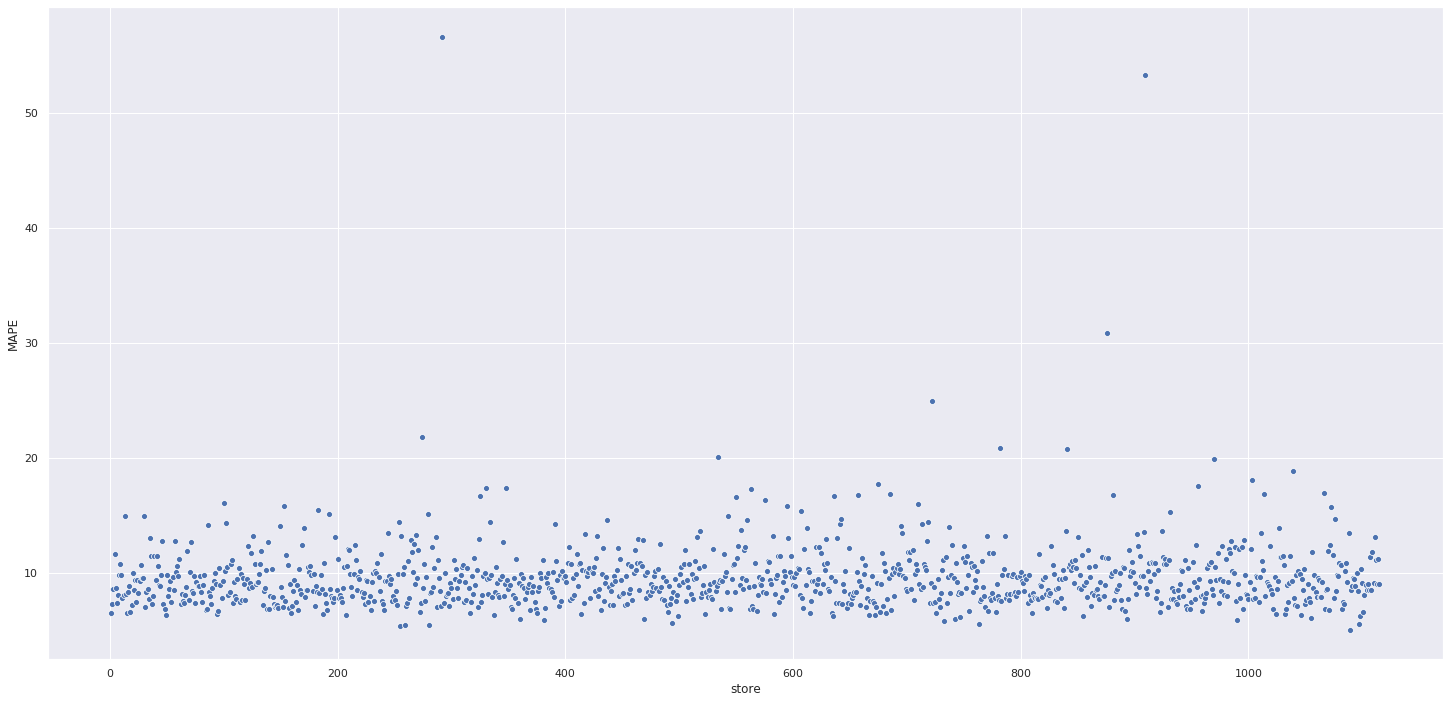

In [47]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Performance Total

In [48]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'scenario', 0: 'values'})
df93['values'] = df93['values'].map('${:,.2f}'.format)
df93

,scenario,values
0,predictions,"R$285,507,228.42"
1,worst_scenario,"R$284,775,307.37"
2,best_scenario,"R$286,239,149.47"


## 9.3. Machine Learning Performance

In [49]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

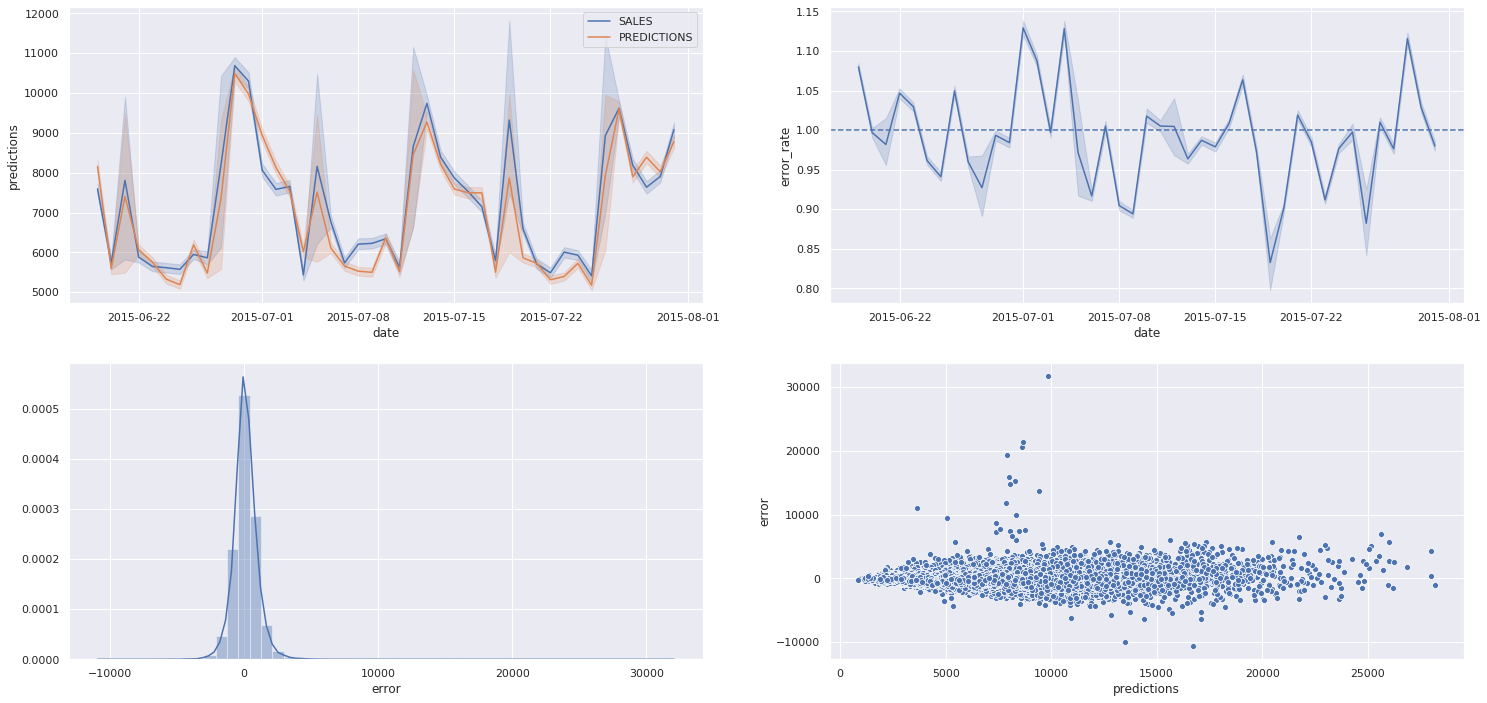

In [50]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0. PASSO 10 - MODELO EM PRODUÇÃO

## 10.1. Rossmann Class

In [21]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/media/ederson/Arquivos/MeusArquivos-Ederson/Cursos/Comunidade_DS/proj_vendas_rossmann_regression/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        

    def data_cleaning(self, df1): 
    
        ## 1.1. Rename Columns (without 'Sales', 'Customers')
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore(x)
        
        cols_new = map(snakecase, cols_old)
        
        df1.columns = cols_new


        ## 1.3. Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        
        ## 1.5. Fillout NA
        # competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
        
        # competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if 
                                                        math.isnan(x['competition_open_since_month']) else 
                                                        x['competition_open_since_month'], axis=1)
        
        # competition_open_since_year
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if 
                                                        math.isnan(x['competition_open_since_year']) else 
                                                        x['competition_open_since_year'], axis=1)
        
        # promo2_since_week 
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if 
                                             math.isnan(x['promo2_since_week']) else 
                                             x['promo2_since_week'], axis=1)
        
        # promo2_since_year
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if 
                                             math.isnan(x['promo2_since_year']) else 
                                             x['promo2_since_year'], axis=1)
        
        # promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 
                     9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)
        
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 
                                                                     1 if x['month_map'] in 
                                                                     x['promo_interval'].split(',') else 0, axis=1)
        
        ## 1.6. Change Types
        
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1


    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
        
        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], 
                                                                         month=x['competition_open_since_month'], 
                                                                         day=1), axis=1)
        
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        
        df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                                            datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)
        
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                          'easter_holiday' if x == 'b' else 
                                                          'christmas' if x == 'c' else 'regular_day')
        
        # 3.0 STEP 03 - FEATURE FILTERING
        
        ## 3.1. Rows Filtering (without 'sales')
        
        df2 = df2[df2['open'] != 0]
        
        ## 3.2. Columns Selection (without 'customers')
        
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2


    def data_preparation(self, df5):
    
        ## 5.2. Rescaling
        # competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
    
        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
    
        ### 5.3.1. Enconding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])
    
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
    
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)
    
        ### 5.3.3. Nature Transformation
        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
        
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
        
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
        
        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                         'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                         'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [26]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open('/media/ederson/Arquivos/MeusArquivos-Ederson/Cursos/Comunidade_DS/proj_vendas_rossmann_regression/models/model_rossmann.pkl', 'rb'))

# initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique exemple
            test_raw = pd.DataFrame(test_json, index=[0])
    
        else: # multiple exemple
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instantiate Rossmann class
        pipeline = Rossmann()
    
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
                
        # data preparation
        df3 = pipeline.data_preparation(df2)
                
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response 
  
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3. Teste da API

In [9]:
import requests

In [17]:
# loading test dataset
df10 = pd.read_csv('/media/ederson/Arquivos/MeusArquivos-Ederson/Cursos/Comunidade_DS/proj_vendas_rossmann_regression/data/raw/test.csv')

In [18]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
#df_test = df_test[df_test['Store'] == 22]
df_test = df_test[df_test['Store'].isin([24, 12, 22])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]

# choose not null
df_test = df_test[~df_test['Open'].isnull()]

# remove Id
df_test = df_test.drop('Id', axis=1)

In [19]:
# convert DataFrame to json
data = json.dumps(df_test.to_dict(orient='records'))

In [20]:
# API Call
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-model-ederson.herokuapp.com/rossmann/predict' 
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [21]:
# transformando a chamada em DataFrame
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [22]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,5865.941406
1,22,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,4644.663086
2,24,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,extended,4590.0,3,2000,1,40,2011,"Jan,Apr,Jul,Oct",Sep,0,2015,9,17,38,2015-37,2000-03-01T00:00:00.000Z,189,2011-09-26T00:00:00.000Z,207,7612.877930
3,12,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,extended,1070.0,9,2015,1,13,2010,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2010-03-22T00:00:00.000Z,286,6372.784668
4,22,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,1040.0,9,2015,1,22,2012,"Jan,Apr,Jul,Oct",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2012-05-21T00:00:00.000Z,173,5054.922363


In [23]:
# Soma de quanto irá vender nas próximas 6 semanas (previsão do modelo)
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell ${:,.2f} on the next 6 weeks.'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction']))

Store Number 12 will sell R$213,654.77 on the next 6 weeks.
Store Number 22 will sell R$174,478.78 on the next 6 weeks.
Store Number 24 will sell R$311,272.79 on the next 6 weeks.
